In [ ]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, f_oneway, pearsonr, linregress, spearmanr
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.optimize import curve_fit

# Download latest version
dataset_path = kagglehub.dataset_download("jocelyndumlao/soil-data-grevena")

# Find the 'SOIL DATA GR.xlsx' file within the dataset directory
# Changed the file name to match the actual file name in the dataset.
for root, dirs, files in os.walk(dataset_path):
    if "SOIL DATA GR.xlsx" in files:
        file_path = os.path.join(root, "SOIL DATA GR.xlsx")
        break
else:
    raise FileNotFoundError("SOIL DATA GR.xlsx not found in the dataset directory.")

print("Path to dataset files:", file_path)

# Read the Excel file using pandas
df = pd.read_excel(file_path)  # Changed to pd.read_excel to read the xlsx file
df = df.dropna()
df.head()

Path to dataset files: /home/florian/.cache/kagglehub/datasets/jocelyndumlao/soil-data-grevena/versions/1/r7tjn68rmw-1/SOIL DATA GR.xlsx


,ID,Sand %,Clay %,Silt %,pH,EC mS/cm,O.M. %,CACO3 %,N_NO3 ppm,P ppm,K ppm,Mg ppm,Fe ppm,Zn ppm,Mn ppm,Cu ppm,B ppm
0,1,42.0,38.0,20.0,5.162,0.274,3.783414,0.00,14.462366,18.608840,147,1115,91.32,0.894,27.06,1.768,0.40
1,2,54.0,26.0,20.0,6.071,0.355,1.451688,0.00,14.587814,32.742137,180,1055,60.04,3.660,17.58,1.684,0.41
2,3,28.0,36.0,36.0,6.921,0.675,1.767599,0.40,14.910394,19.024525,183,1215,61.24,3.060,18.00,1.840,0.46
3,4,58.0,20.0,22.0,7.704,0.355,0.718322,6.80,4.211470,6.276846,116,327,19.54,1.640,5.04,0.844,0.50
4,5,33.2,41.2,25.6,7.609,0.392,0.996625,4.39,6.111111,6.553970,228,939,25.84,0.180,7.16,1.216,0.40


#I) Analyse fondamentale

La raison pour laquelle il est important de faire une analyse fondamentale des données et pour ne pas se précipiter dans l'analyse statistiques sans comprendre au préalable les définitions des variables. Toute l’analyse fondamentale de ce jeu de données sera effectuée à partir de la publication suivante :
https://doi.org/10.1016/j.dib.2022.108408

1) Quoi?

Ce jeu de données correspond à des analyses de sol.

Sand % : pourcentage de sable,
Clay % : pourcentage d’argile,
Silt % : pourcentage de limon,
pH : mesure de l’acidité du sol,
EC (Electrical Conductivity) : salinité ou conductivité du sol due aux sels, exprimée en mS/cm,
O.M (Organic Matter) : pourcentage de matière organique,
CACO3 % : pourcentage de CaCO₃,
Les autres valeurs indiquent la quantité (en ppm) de composés chimiques : NNO3 (nitrate), P (phosphore), K (potassium), Mg (magnésium), Fe (fer), Zn (zinc), Mn (manganèse), Cu (cuivre) et B (bore).

2) Qui?

Le document précise que c’est l’Institut de recherche sur le sol et l’eau (SWRI) qui a collecté les données. Selon le site de la SWRI (https://www.swri.gr/index.php/en/), il s’agit de la plus grande institution universitaire de Grèce dans le domaine de la protection et de la gestion des sols et des ressources en eau, couvrant un large éventail de problématiques scientifiques associées.

Cela signifie que l’institut dispose d’une véritable expertise dans ce domaine. D’après le journal scientifique, ces données sont destinées aux coopératives agricoles, aux agriculteurs individuels, aux industries productrices d’engrais ou encore à divers instituts de recherche.

3) Quand?

Les données ont été recueillies au cours d’une étude réalisée entre 2015 et 2019, principalement à l’automne et au début de l’hiver de chaque année. Les auteurs indiquent qu’il est toujours possible d’utiliser ces données afin d’évaluer la qualité des sols pour certaines activités agricoles.

Les données disponibles sur Kaggle ne sont plus mises à jour depuis la fin de l’étude.

4) Où?

Les données proviennent de Grèce, plus précisément de l’unité régionale de Grevena. L’altitude de cette zone varie d’environ 500 m au-dessus du niveau de la mer à 900 m plus au nord, et la région s’étend sur environ 270 km².

5) Comment?

Les données ont été collectées dans 781 emplacements. À chaque emplacement, 2 à 3 échantillons représentatifs de sol peu profond (0-30 cm) ont été prélevés à proximité les uns des autres, puis regroupés pour former un échantillon composite. Les distances minimales entre deux points d’échantillonnage sont d’environ 50 m, et la distance moyenne est d’environ 300 m.

Après prélèvement à l’aide d’une tarière, les sols ont été séchés à l’air libre. L’extraction et la détermination des éléments nutritifs disponibles pour les plantes ont été effectuées conformément aux protocoles de Soil Testing and Plant Analysis. La qualité des données fournies est vérifiée via la plateforme WEPAL : deux fois par an, quatre échantillons de sol sont analysés selon des paramètres prédéfinis et les résultats sont comparés à ceux d’autres laboratoires.

6) Pourquoi?

Cet ensemble de données peut être utilisé pour évaluer l’état du sol dans le cadre de diverses activités. Il permet également de mieux connaître les propriétés du sol, afin d’augmenter le rendement, d’améliorer la qualité des produits, de réduire les intrants inutiles et de prévenir une éventuelle pollution des eaux de surface et souterraines.

Il offre aussi la possibilité de concevoir des outils innovants, tels que des scanners portables pour une surveillance rapide et en temps réel des sols sur le terrain. Enfin, ces données peuvent servir à élaborer des cartographies de la région et à visualiser les 781 sites d’échantillonnage.

II) Analyse technique
Dans ce jeu de données, seules des variables continues sont présentes.

1) Analyse statistique univariée des éléments nutritifs
Les principaux éléments nutritifs pour la fertilisation d’un sol sont l’azote (N), le phosphore (P) et le potassium (K). Pour qu’un sol soit fertile, il est nécessaire de disposer de ces trois éléments en quantité suffisante. Les autres nutriments sont également importants pour augmenter les rendements et prévenir les maladies.

In [2]:
df[["N_NO3 ppm", "P ppm", "K ppm ", "Mg ppm", "Fe ppm", "Zn ppm", "Mn ppm", "Cu ppm", "B ppm"]].describe()

,N_NO3 ppm,P ppm,K ppm,Mg ppm,Fe ppm,Zn ppm,Mn ppm,Cu ppm,B ppm
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,11.630888,13.840185,296.325641,820.741026,31.163188,0.675016,15.870457,2.032557,0.383624
std,11.057154,14.595370,194.566149,742.662559,26.006211,0.681219,15.169155,2.457079,0.222139
min,0.180000,1.070000,31.000000,60.000000,4.630000,0.100000,2.380000,0.210000,0.100000
25%,5.280000,5.727500,169.000000,363.500000,13.210000,0.310000,6.749250,1.080000,0.230000
50%,8.870000,9.480000,255.000000,567.000000,19.815000,0.481000,10.105000,1.480000,0.350000
75%,14.320000,15.987500,358.500000,1001.000000,42.947500,0.773250,19.162500,2.130000,0.472500
max,120.640000,152.420000,1665.000000,4836.000000,187.940000,7.090000,189.210000,33.910000,1.900000


On observe qu’il y a, en moyenne, des teneurs élevées en potassium et en magnésium dans les 781 sols prélevés à Grévéna entre 2015 et 2019. En revanche, la teneur en fer reste moyenne dans ces mêmes sols.

En ce qui concerne l’azote, le phosphore et le manganèse, leurs concentrations sont relativement faibles. On note également une très faible quantité de cuivre et la présence de traces de zinc et de bore.

Selon l’article, il existe une carence critique en phosphore en-dessous de 15 ppm. Les données montrent qu’en moyenne, les sols de Grévéna ne possèdent pas suffisamment de phosphore pour répondre à cette exigence.

Pour les autres nutriments, il convient d’abord de déterminer les besoins et la tolérance de la culture ciblée à certaines carences, avant d’adapter les apports d’engrais en conséquence.

Nous allons maintenant examiner la répartition de chaque nutriment.

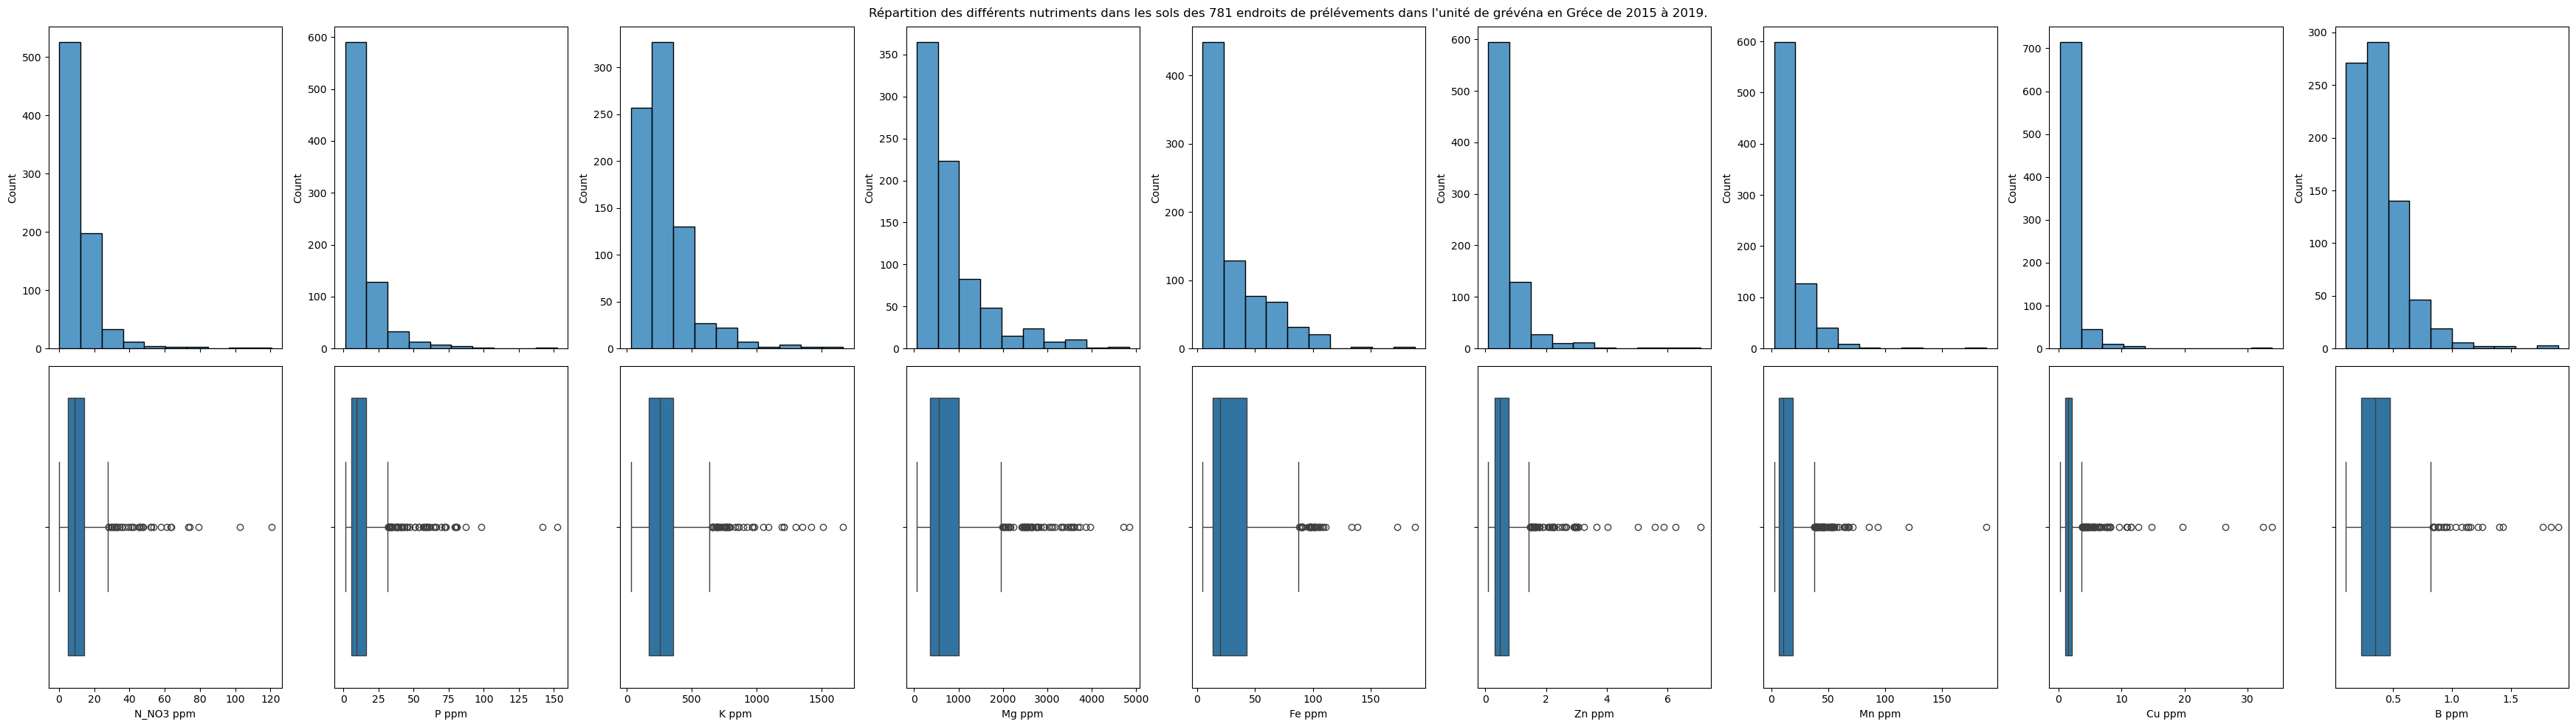

In [3]:
fig, ax = plt.subplots(2, 9, sharex="col")
fig.set_size_inches(35, 10)
plt.suptitle("Répartition des différents nutriments dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.histplot(data = df, x="N_NO3 ppm", bins = 10, ax=ax[0, 0])
sns.boxplot(data = df, x="N_NO3 ppm", ax=ax[1, 0])
sns.histplot(data = df, x="P ppm", bins = 10, ax=ax[0, 1])
sns.boxplot(data = df, x="P ppm", ax=ax[1, 1])
sns.histplot(data = df, x="K ppm ", bins = 10, ax=ax[0, 2])
sns.boxplot(data = df, x="K ppm ", ax=ax[1, 2])
sns.histplot(data = df, x="Mg ppm", bins = 10, ax=ax[0, 3])
sns.boxplot(data = df, x="Mg ppm", ax=ax[1, 3])
sns.histplot(data = df, x="Fe ppm", bins = 10, ax=ax[0, 4])
sns.boxplot(data = df, x="Fe ppm", ax=ax[1, 4])
sns.histplot(data = df, x="Zn ppm", bins = 10, ax=ax[0, 5])
sns.boxplot(data = df, x="Zn ppm", ax=ax[1, 5])
sns.histplot(data = df, x="Mn ppm", bins = 10, ax=ax[0, 6])
sns.boxplot(data = df, x="Mn ppm", ax=ax[1, 6])
sns.histplot(data = df, x="Cu ppm", bins = 10, ax=ax[0, 7])
sns.boxplot(data = df, x="Cu ppm", ax=ax[1, 7])
sns.histplot(data = df, x="B ppm", bins = 10, ax=ax[0, 8])
sns.boxplot(data = df, x="B ppm", ax=ax[1, 8])
fig.tight_layout()
plt.show()

On constate que tous les nutriments ne suivent pas une loi normale. De plus, la majorité des valeurs relevées pour la plupart des sols se situe dans la fourchette basse de chaque distribution. On observe également que les histogrammes présentent un profil assez similaire et que, dans tous les boxplots, de nombreuses valeurs aberrantes apparaissent sur la partie droite de la distribution.

En ce qui concerne spécifiquement le phosphore, l’examen de la médiane et du boxplot suggère que plus de 50 % des sols ne disposent pas d’une quantité suffisante de phosphore. Il serait donc indispensable d’utiliser des engrais à base de phosphore afin d’améliorer la fertilité de ces sols.

2) Analyse de la texture des sols dans les 781 zones de prélèvement à Grévéna (2015-2019)

Nous allons à présent examiner l’influence du pourcentage de sable, de limon et d’argile sur les nutriments. Pour ce faire, nous commençons par une analyse univariée.

In [4]:
df[['Sand %', 'Clay %',	'Silt %']].describe().round()

,Sand %,Clay %,Silt %
count,780.0,780.0,780.0
mean,32.0,35.0,33.0
std,11.0,11.0,8.0
min,10.0,6.0,14.0
25%,24.0,28.0,28.0
50%,30.0,36.0,32.0
75%,38.0,44.0,38.0
max,70.0,64.0,68.0


Les moyennes du pourcentage de sable, d’argile et de limon dans les 781 zones de prélèvement à Grévéna (Grèce), entre 2015 et 2019, sont respectivement de 32 %, 35 % et 33 %. Examinons maintenant la répartition de ces valeurs.

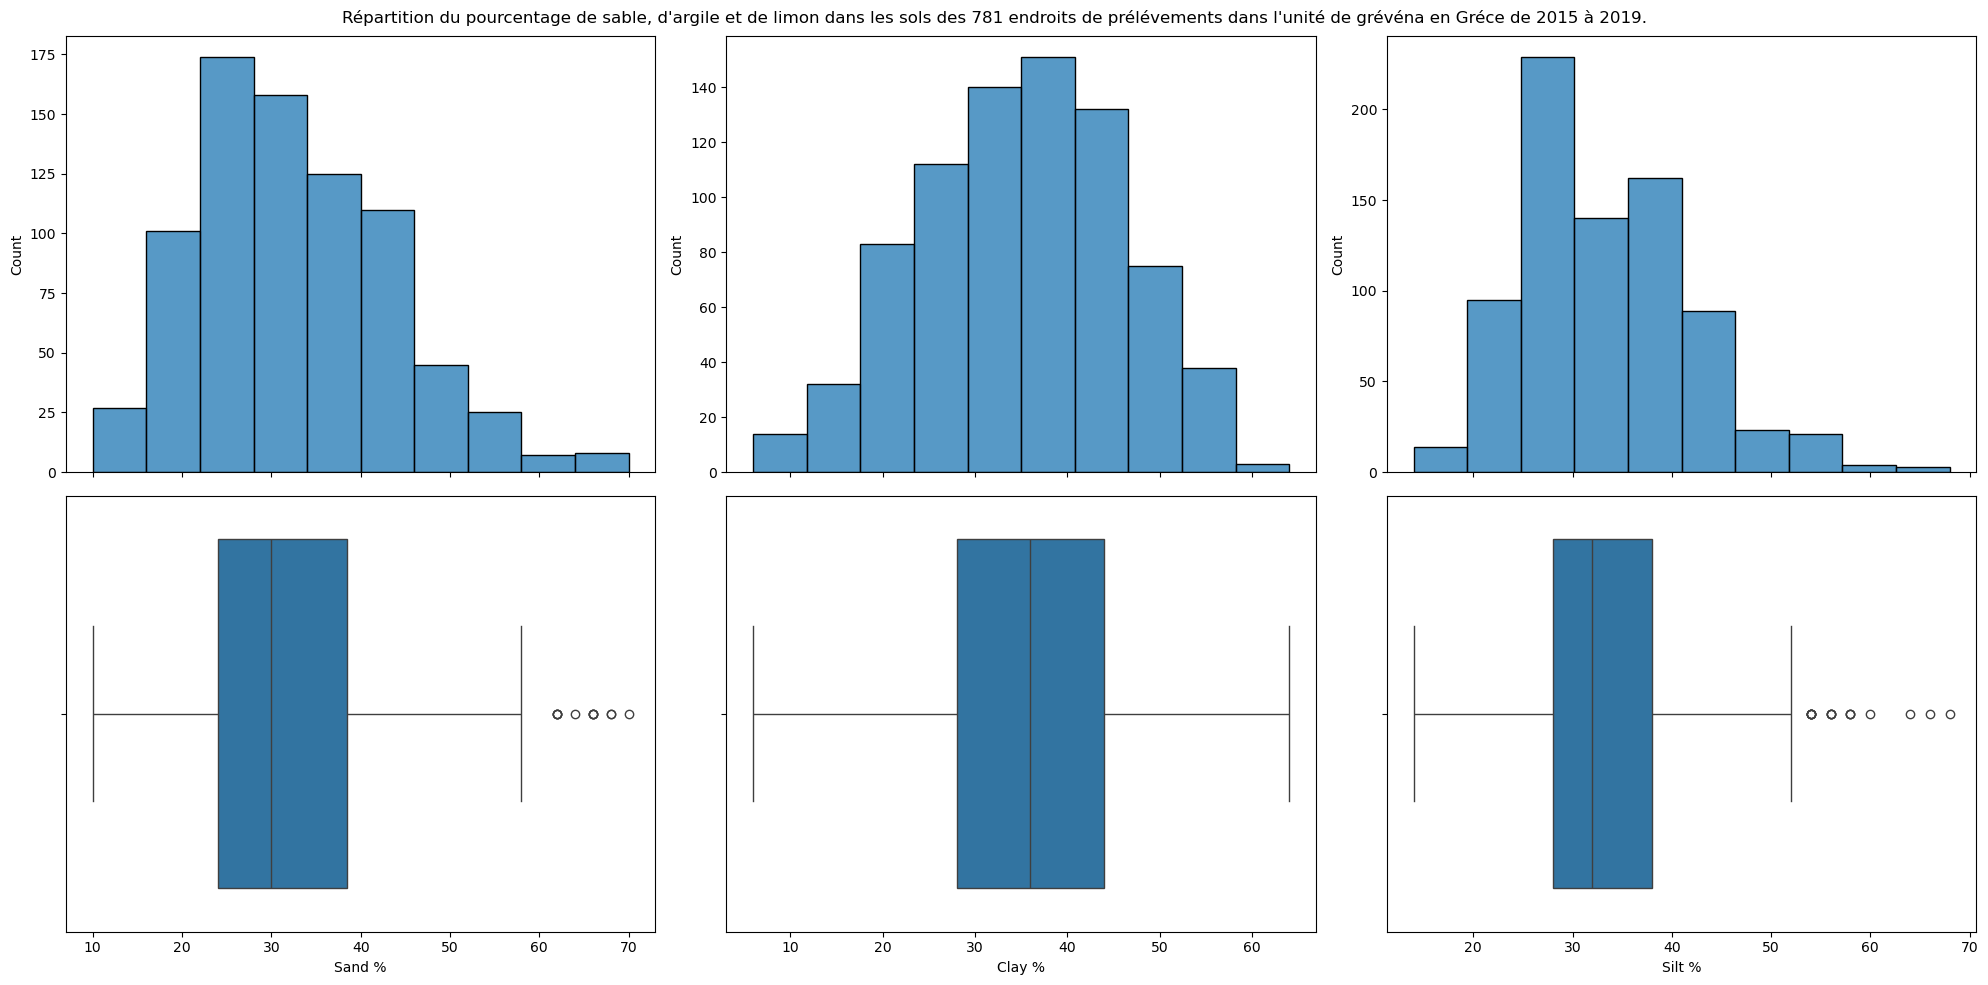

In [5]:
fig, ax = plt.subplots(2, 3, sharex="col")
fig.set_size_inches(20, 10)
plt.suptitle("Répartition du pourcentage de sable, d'argile et de limon dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.histplot(data = df, x="Sand %", bins = 10, ax=ax[0, 0])
sns.boxplot(data = df, x="Sand %", ax=ax[1, 0])
sns.histplot(data = df, x="Clay %", bins = 10, ax=ax[0, 1])
sns.boxplot(data = df, x="Clay %", ax=ax[1, 1])
sns.histplot(data = df, x="Silt %", bins = 10, ax=ax[0, 2])
sns.boxplot(data = df, x="Silt %", ax=ax[1, 2])
fig.tight_layout()
plt.show()

La plupart des sols du jeu de données présentent entre 20 % et 45 % de sable, entre 20 % et 50 % d’argile et entre 20 % et 45 % de limon. Les trois variables suivent une distribution normale. On recense 5 valeurs aberrantes (outliers) sur le boxplot relatif au sable et 7 pour celui du limon, tandis qu’il n’y en a aucune pour l’argile.

Nous allons à présent visualiser, de manière générale, l’influence de chacune de ces variables sur les nutriments.

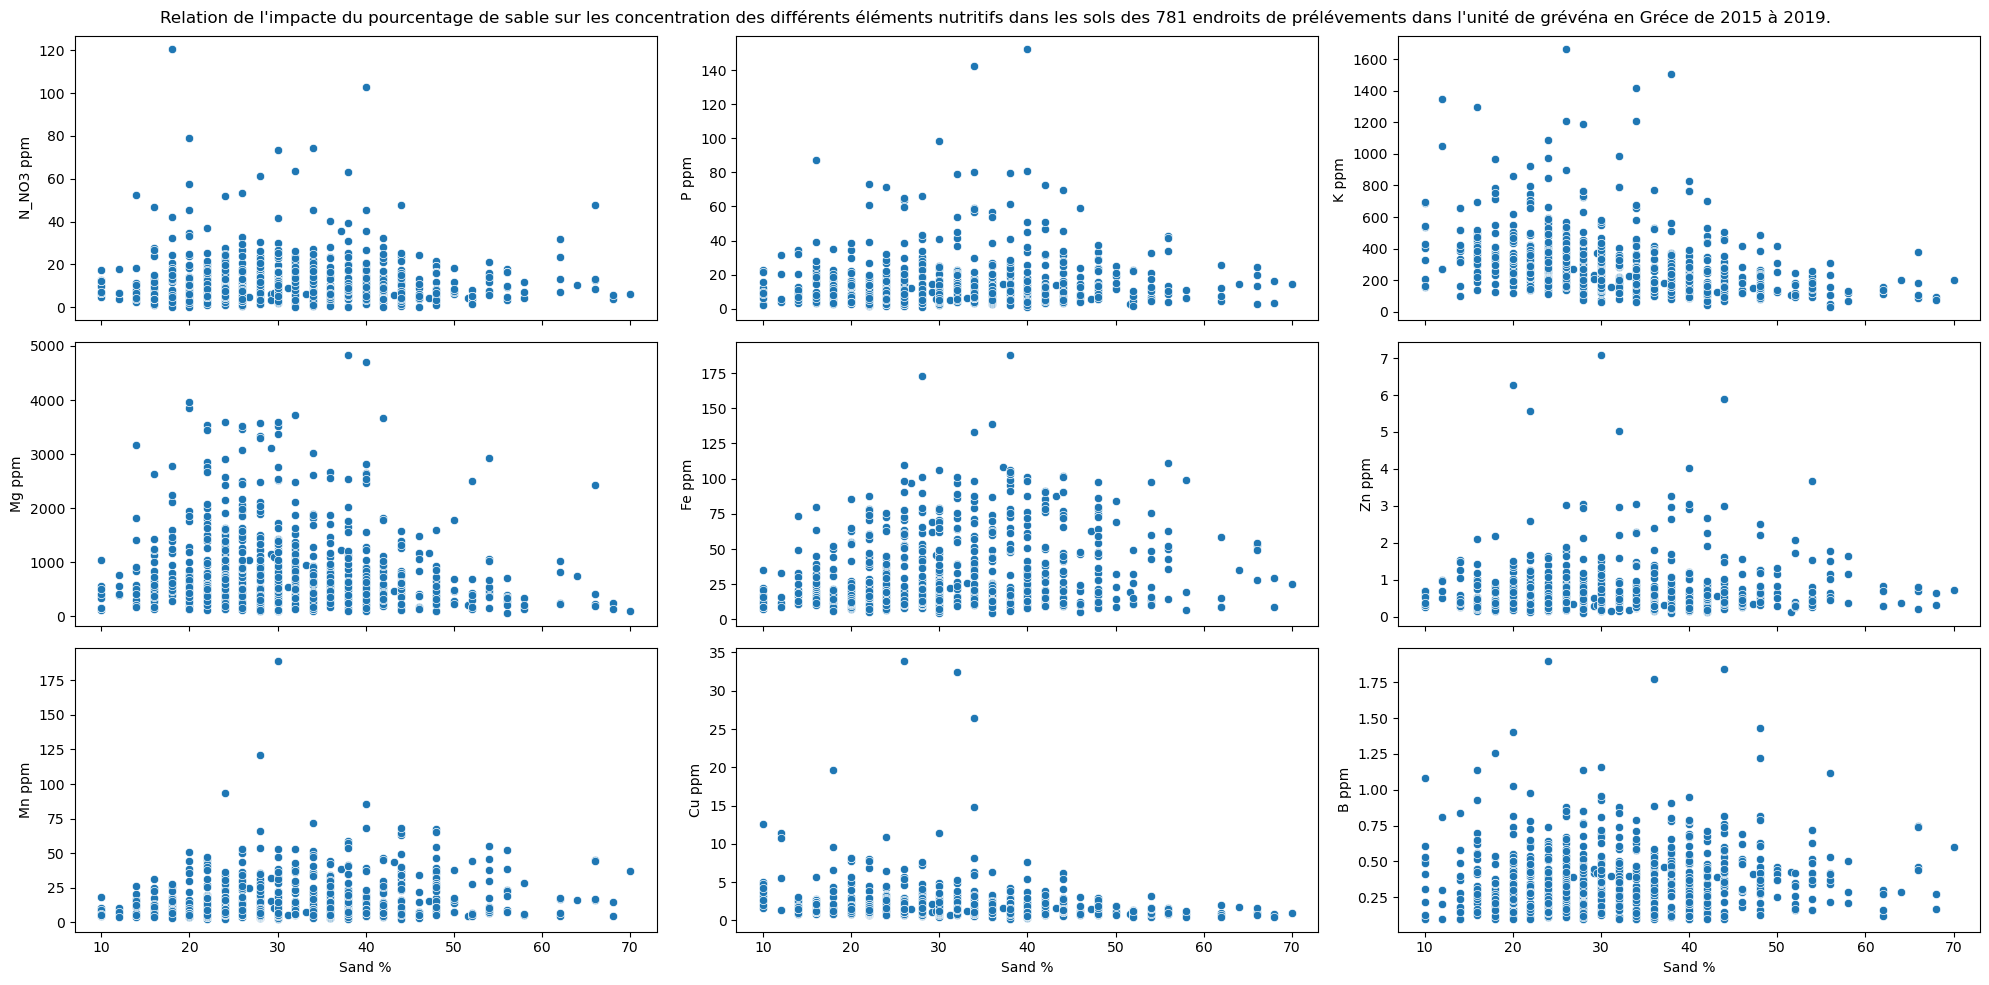

In [6]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation de l'impacte du pourcentage de sable sur les concentration des différents éléments nutritifs dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")

#create pie chart
sns.scatterplot(data = df, x="Sand %", y = "N_NO3 ppm", ax=ax[0, 0])
sns.scatterplot(data = df, x="Sand %", y = "P ppm", ax=ax[0, 1])
sns.scatterplot(data = df, x="Sand %", y = "K ppm ",ax=ax[0, 2])
sns.scatterplot(data = df, x="Sand %", y = "Mg ppm", ax=ax[1, 0])
sns.scatterplot(data = df, x="Sand %", y = "Fe ppm",ax=ax[1, 1])
sns.scatterplot(data = df, x="Sand %", y = "Zn ppm",ax=ax[1, 2])
sns.scatterplot(data = df, x="Sand %", y = "Mn ppm",ax=ax[2, 0])
sns.scatterplot(data = df, x="Sand %", y = "Cu ppm",ax=ax[2, 1])
sns.scatterplot(data = df, x="Sand %", y = "B ppm",ax=ax[2, 2])
fig.tight_layout()
plt.show()

Nous n’observons pas de relation particulière entre la teneur en sable et les différents éléments nutritifs. Nous allons donc procéder à des tests d’hypothèse. Étant donné que les nutriments ne suivent pas une loi normale, nous utiliserons un test de corrélation de Spearman.

In [7]:
print(spearmanr(df["N_NO3 ppm"], df["Sand %"]))
print(spearmanr(df["P ppm"], df["Sand %"]))
print(spearmanr(df["K ppm "], df["Sand %"]))
print(spearmanr(df["Mg ppm"], df["Sand %"]))
print(spearmanr(df["Fe ppm"], df["Sand %"]))
print(spearmanr(df["Zn ppm"], df["Sand %"]))
print(spearmanr(df["Mn ppm"], df["Sand %"]))
print(spearmanr(df["Cu ppm"], df["Sand %"]))
print(spearmanr(df["B ppm"], df["Sand %"]))

SignificanceResult(statistic=-0.01848700562346876, pvalue=0.6061827193720623)
SignificanceResult(statistic=0.0863775829267555, pvalue=0.015820212569043125)
SignificanceResult(statistic=-0.46886712346090226, pvalue=6.974968901454773e-44)
SignificanceResult(statistic=-0.128401742358217, pvalue=0.00032413449376071424)
SignificanceResult(statistic=0.15956277707793112, pvalue=7.537421495802628e-06)
SignificanceResult(statistic=0.11442658318067238, pvalue=0.001368777272936568)
SignificanceResult(statistic=0.17939373189029395, pvalue=4.579880837922173e-07)
SignificanceResult(statistic=-0.21337957726465492, pvalue=1.7521006479221194e-09)
SignificanceResult(statistic=0.08146577266824406, pvalue=0.022884986248801274)


Il n’existe pas de corrélation marquée entre la teneur en sable et les différents nutriments.

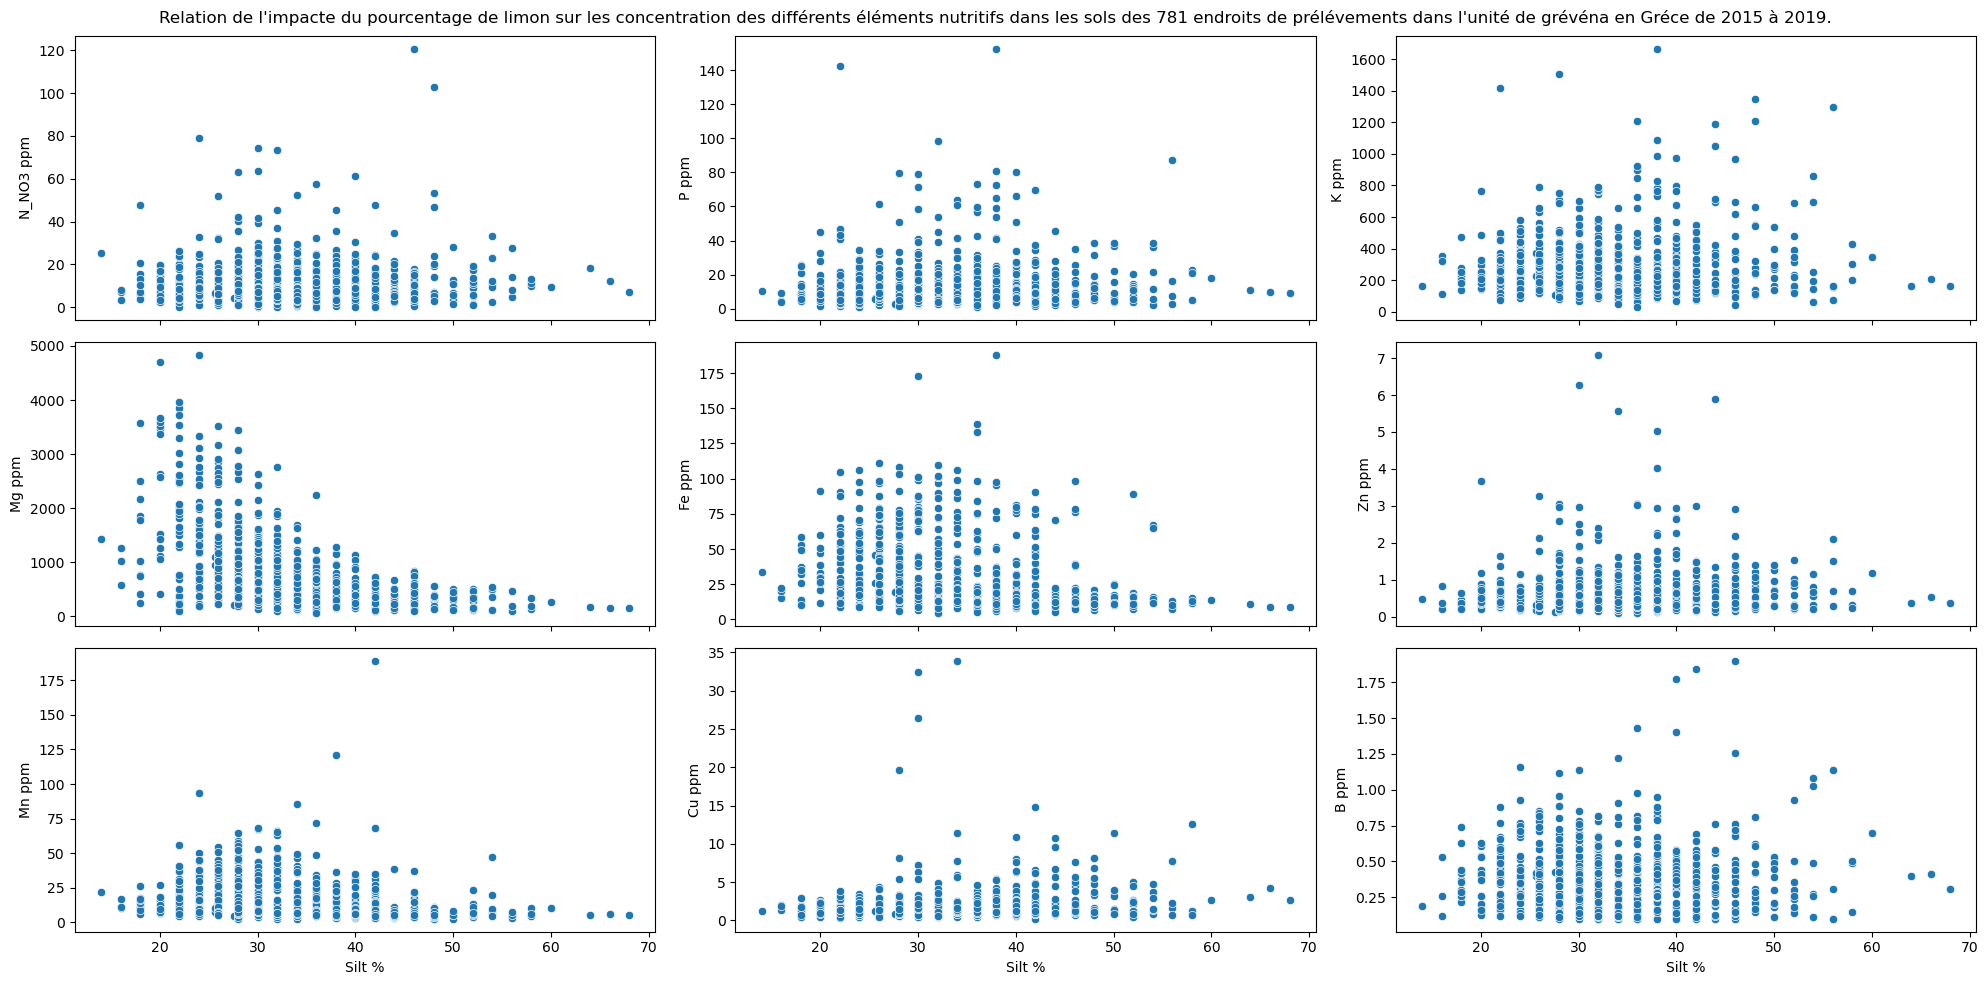

In [8]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation de l'impacte du pourcentage de limon sur les concentration des différents éléments nutritifs dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")

#create pie chart
sns.scatterplot(data = df, x="Silt %", y = "N_NO3 ppm", ax=ax[0, 0])
sns.scatterplot(data = df, x="Silt %", y = "P ppm", ax=ax[0, 1])
sns.scatterplot(data = df, x="Silt %", y = "K ppm ",ax=ax[0, 2])
sns.scatterplot(data = df, x="Silt %", y = "Mg ppm", ax=ax[1, 0])
sns.scatterplot(data = df, x="Silt %", y = "Fe ppm",ax=ax[1, 1])
sns.scatterplot(data = df, x="Silt %", y = "Zn ppm",ax=ax[1, 2])
sns.scatterplot(data = df, x="Silt %", y = "Mn ppm",ax=ax[2, 0])
sns.scatterplot(data = df, x="Silt %", y = "Cu ppm",ax=ax[2, 1])
sns.scatterplot(data = df, x="Silt %", y = "B ppm",ax=ax[2, 2])
fig.tight_layout()
plt.show()

On observe une relation potentielle entre la teneur en magnésium et le pourcentage de limon. Nous allons donc vérifier ces corrélations plus en détail.

In [9]:
print(spearmanr(df["N_NO3 ppm"], df["Silt %"]))
print(spearmanr(df["P ppm"], df["Silt %"]))
print(spearmanr(df["K ppm "], df["Silt %"]))
print(spearmanr(df["Mg ppm"], df["Silt %"]))
print(spearmanr(df["Fe ppm"], df["Silt %"]))
print(spearmanr(df["Zn ppm"], df["Silt %"]))
print(spearmanr(df["Cu ppm"], df["Silt %"]))
print(spearmanr(df["B ppm"], df["Silt %"]))

SignificanceResult(statistic=0.014011657882324198, pvalue=0.6960072424871562)
SignificanceResult(statistic=0.006691730424872987, pvalue=0.8519803632532416)
SignificanceResult(statistic=-0.040719601673526264, pvalue=0.25600516923799954)
SignificanceResult(statistic=-0.5439955429651977, pvalue=2.7649425553904398e-61)
SignificanceResult(statistic=-0.3429076211007175, pvalue=6.076873025477479e-23)
SignificanceResult(statistic=0.08472773139815516, pvalue=0.017943652670095622)
SignificanceResult(statistic=0.10142891576866427, pvalue=0.004574999400717602)
SignificanceResult(statistic=-0.025744928925234715, pvalue=0.47276800343542114)


On observe une corrélation significative dans le cas du magnésium, indiquant une relation entre la teneur en limon et la concentration en magnésium. Ainsi, pour augmenter la teneur en magnésium dans les sols, il faudrait réduire leur proportion de limon.

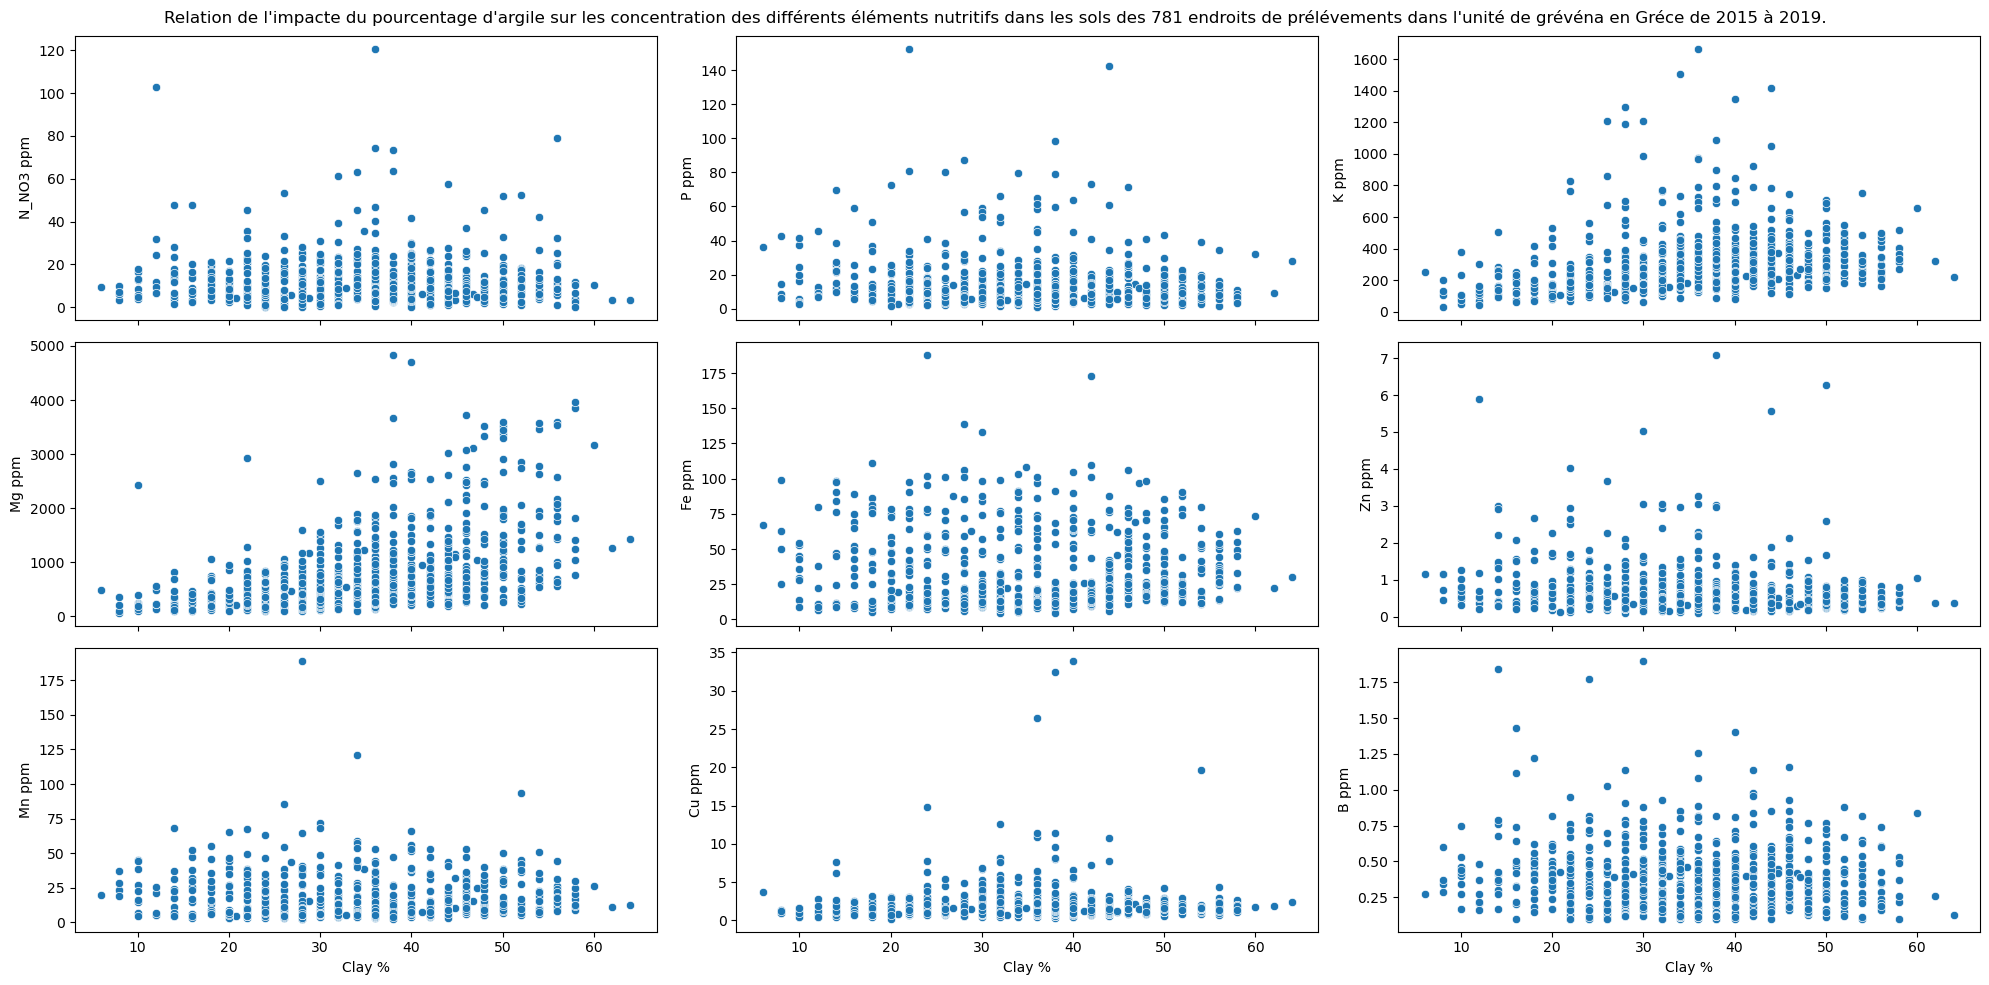

In [10]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation de l'impacte du pourcentage d'argile sur les concentration des différents éléments nutritifs dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")

#create pie chart
sns.scatterplot(data = df, x="Clay %", y = "N_NO3 ppm", ax=ax[0, 0])
sns.scatterplot(data = df, x="Clay %", y = "P ppm", ax=ax[0, 1])
sns.scatterplot(data = df, x="Clay %", y = "K ppm ",ax=ax[0, 2])
sns.scatterplot(data = df, x="Clay %", y = "Mg ppm", ax=ax[1, 0])
sns.scatterplot(data = df, x="Clay %", y = "Fe ppm",ax=ax[1, 1])
sns.scatterplot(data = df, x="Clay %", y = "Zn ppm",ax=ax[1, 2])
sns.scatterplot(data = df, x="Clay %", y = "Mn ppm",ax=ax[2, 0])
sns.scatterplot(data = df, x="Clay %", y = "Cu ppm",ax=ax[2, 1])
sns.scatterplot(data = df, x="Clay %", y = "B ppm",ax=ax[2, 2])
fig.tight_layout()
plt.show()

Nous observons des relations dans le cas du magnésium et du potassium. Passons à présent aux tests d’hypothèse.

In [11]:
print(spearmanr(df["N_NO3 ppm"], df["Clay %"]))
print(spearmanr(df["P ppm"], df["Clay %"]))
print(spearmanr(df["K ppm "], df["Clay %"]))
print(spearmanr(df["Mg ppm"], df["Clay %"]))
print(spearmanr(df["Fe ppm"], df["Clay %"]))
print(spearmanr(df["Zn ppm"], df["Clay %"]))
print(spearmanr(df["Mn ppm"], df["Clay %"]))
print(spearmanr(df["Cu ppm"], df["Clay %"]))
print(spearmanr(df["B ppm"], df["Clay %"]))

SignificanceResult(statistic=0.0021989751657589054, pvalue=0.9511078546834268)
SignificanceResult(statistic=-0.08057499505554355, pvalue=0.024424321548901923)
SignificanceResult(statistic=0.4878651288254976, pvalue=6.982074894127331e-48)
SignificanceResult(statistic=0.5429172221958903, pvalue=5.290984826171913e-61)
SignificanceResult(statistic=0.12330776599050902, pvalue=0.0005575722016467998)
SignificanceResult(statistic=-0.17014477302531927, pvalue=1.7603546753540984e-06)
SignificanceResult(statistic=0.10977141238497767, pvalue=0.0021397688813950084)
SignificanceResult(statistic=0.12898582932702526, pvalue=0.0003041983447731475)
SignificanceResult(statistic=-0.055727238587214865, pvalue=0.11992473019318842)


On observe une influence significative uniquement pour le magnésium. En effet, plus la teneur en argile est élevée, plus la rétention de magnésium augmente.

2) Analyse du pH

In [12]:
df["pH"].describe()

count    780.000000
mean       7.136840
std        0.894011
min        4.490000
25%        6.667500
50%        7.550000
75%        7.780000
max        8.200000
Name: pH, dtype: float64

On observe que le pH moyen des 781 sols prélevés à Grévéna entre 2015 et 2019 est de 7,13, ce qui correspond à un pH neutre.
Selon la publication associée à ce jeu de données, un pH supérieur à 7,5 est considéré comme très basique, tandis qu’un pH inférieur à 6 est jugé très acide. Les valeurs comprises entre 6 et 7,5 sont alors qualifiées de modérées.

In [13]:
print("H0: Les 781 sols prélevé de Grévéna de 2015 à 2019 ont en moyenne un pH neutre de 7.")
alpha = 0.02
p_value = ttest_1samp(df["pH"], popmean=7).pvalue
if p_value < alpha:
    print("Il y a assez d'évidence pour rejeter H0.")
else:
    print("Il n'y a pas assez d'évidence pour rejeter H0.")

H0: Les 781 sols prélevé de Grévéna de 2015 à 2019 ont en moyenne un pH neutre de 7.
Il y a assez d'évidence pour rejeter H0.


Comme nous avons rejeté l’hypothèse nulle (H₀), nous concluons qu’en moyenne, les 781 sols ne sont pas entièrement neutres.

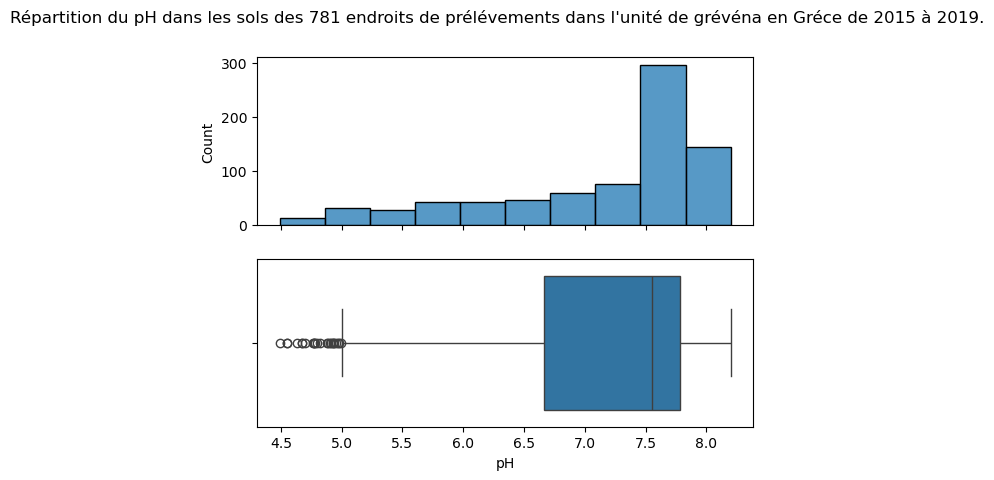

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition du pH dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
plt.xlabel("pH")
sns.histplot(data = df, x="pH", bins = 10, ax=ax[0])
sns.boxplot(data = df, x="pH", ax=ax[1])
plt.show()

On observe que le pH ne suit pas une loi normale. De plus, plus de la moitié des sols présentent un pH > 7,5, c’est-à-dire un pH alcalin selon l’article. Afin de mieux visualiser la répartition, nous allons créer une variable « groupe pH » qui inclura trois catégories : acide, neutre et basique.

In [15]:
conditionlist = [
    (df["pH"] < 6),
    ((df["pH"] >= 6) & (df["pH"] <= 7.5)),
    (df["pH"] > 7.5)
]

choicelist = ["acide", "neutre", "basique"]
df["groupe pH"] = np.select(conditionlist, choicelist, default="Not Specified")
df

,ID,Sand %,Clay %,Silt %,pH,EC mS/cm,O.M. %,CACO3 %,N_NO3 ppm,P ppm,K ppm,Mg ppm,Fe ppm,Zn ppm,Mn ppm,Cu ppm,B ppm,groupe pH
0,1,42.0,38.0,20.0,5.162,0.274,3.783414,0.00,14.462366,18.608840,147,1115,91.32,0.894,27.060,1.768,0.40,acide
1,2,54.0,26.0,20.0,6.071,0.355,1.451688,0.00,14.587814,32.742137,180,1055,60.04,3.660,17.580,1.684,0.41,neutre
2,3,28.0,36.0,36.0,6.921,0.675,1.767599,0.40,14.910394,19.024525,183,1215,61.24,3.060,18.000,1.840,0.46,neutre
3,4,58.0,20.0,22.0,7.704,0.355,0.718322,6.80,4.211470,6.276846,116,327,19.54,1.640,5.040,0.844,0.50,basique
4,5,33.2,41.2,25.6,7.609,0.392,0.996625,4.39,6.111111,6.553970,228,939,25.84,0.180,7.160,1.216,0.40,basique
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,777,26.0,46.0,28.0,6.720,0.454,2.080000,0.00,7.660000,20.670000,395,500,38.07,0.394,26.480,1.468,0.33,neutre
777,778,40.0,28.0,32.0,7.790,0.343,1.380000,30.00,5.200000,4.140000,286,154,12.79,0.241,6.328,0.603,0.12,basique
778,779,34.0,28.0,38.0,7.630,1.135,1.870000,24.30,17.130000,6.900000,582,164,10.73,0.439,5.390,1.141,0.26,basique
779,780,16.0,38.0,46.0,7.730,0.393,1.720000,46.30,3.920000,7.930000,335,572,11.61,0.263,3.770,2.195,0.27,basique


groupe pH
basique    420
neutre     244
acide      116
Name: count, dtype: int64
groupe pH
basique    0.538462
neutre     0.312821
acide      0.148718
Name: proportion, dtype: float64


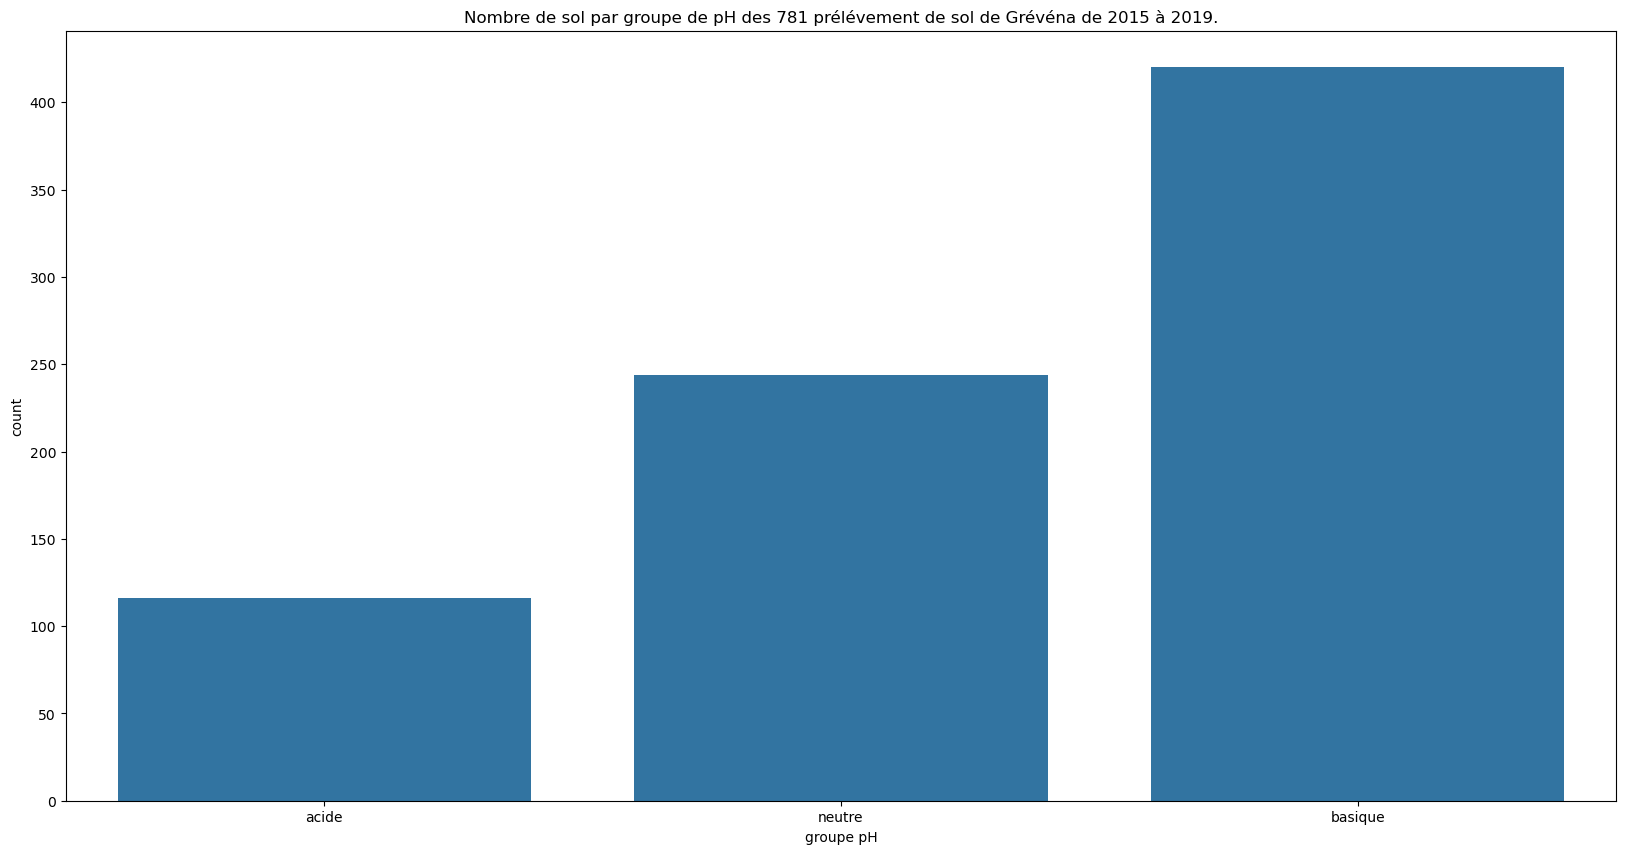

In [16]:
print(df["groupe pH"].value_counts())
print(df["groupe pH"].value_counts(normalize=True))
plt.figure(figsize=(20, 10))
sns.countplot(data = df, x="groupe pH")
plt.title("Nombre de sol par groupe de pH des 781 prélévement de sol de Grévéna de 2015 à 2019.")
plt.show()

Nous observons effectivement qu’une majorité de sols est considérée basique. Toutefois, la proportion de sols neutres représente environ la moitié de celle des sols basiques. Quant aux sols acides, leur nombre correspond à environ un quart de celui des sols basiques. Nous allons maintenant examiner le pH en fonction de la texture.

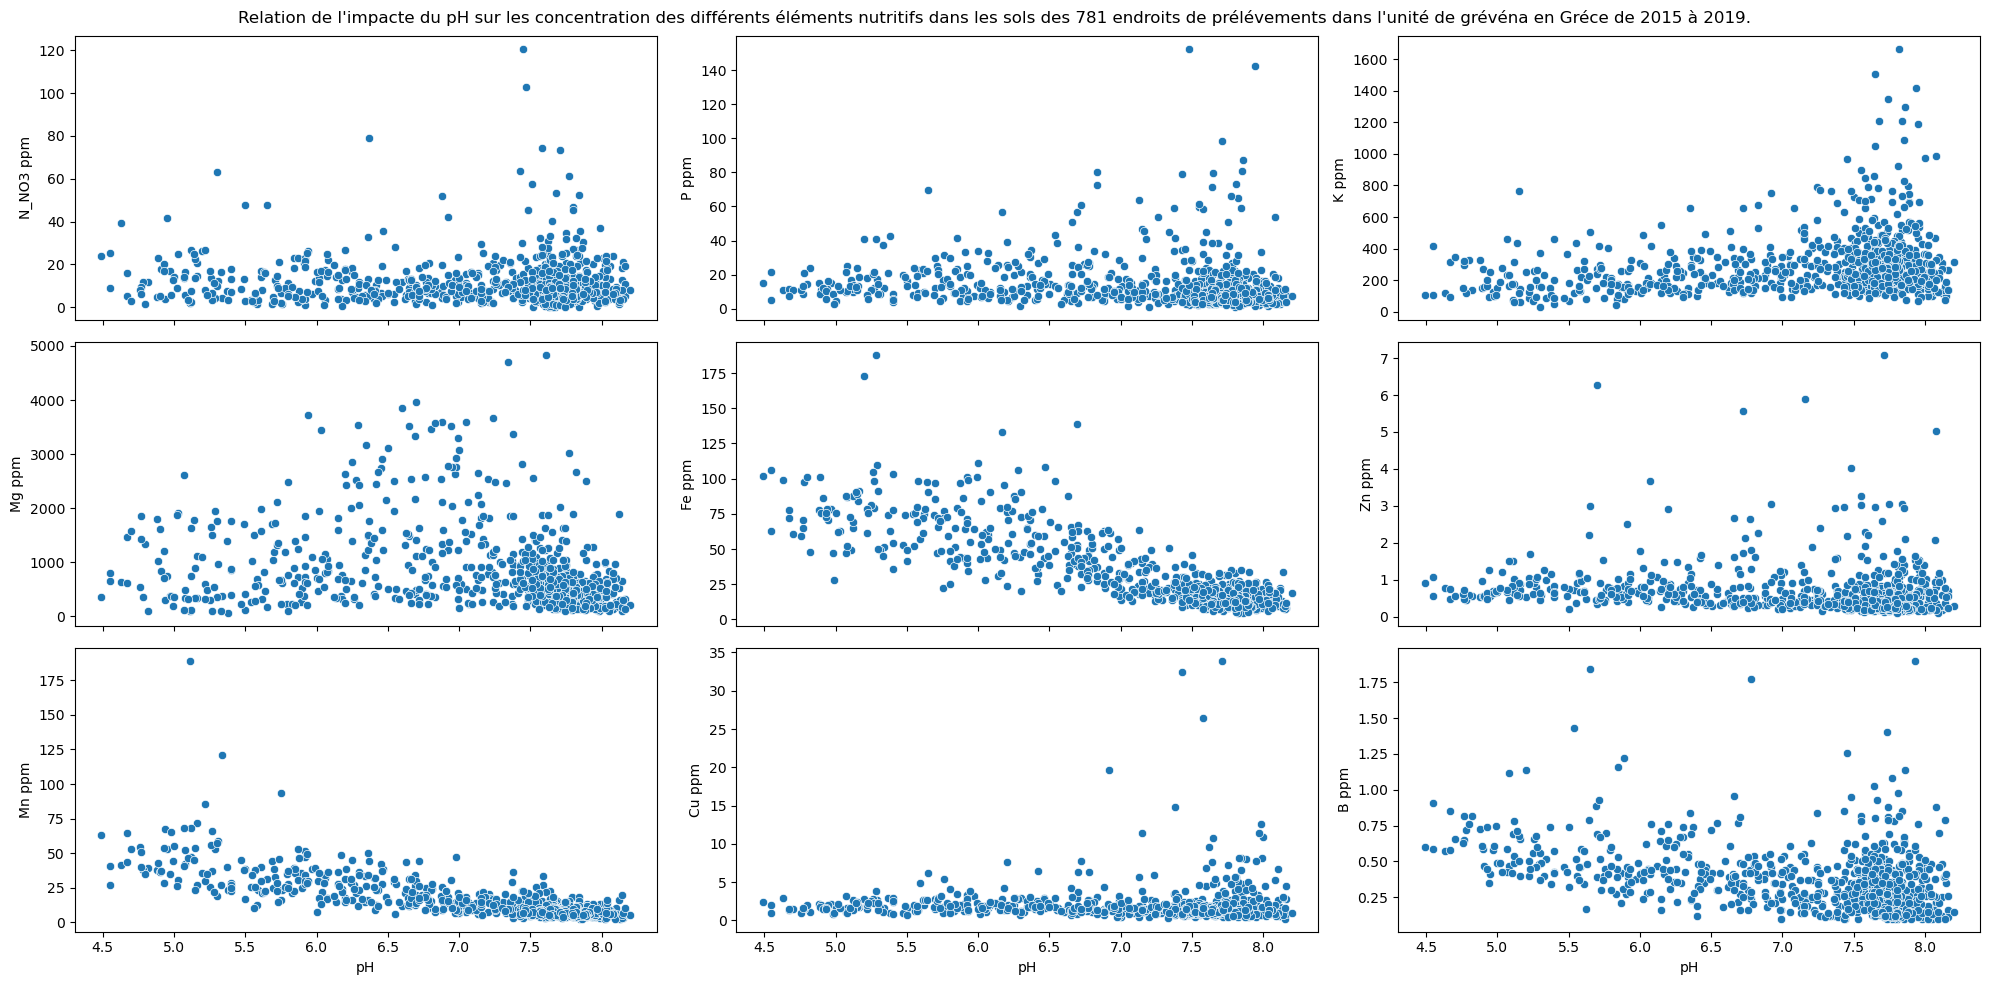

In [17]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation de l'impacte du pH sur les concentration des différents éléments nutritifs dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")

#create pie chart
sns.scatterplot(data = df, x="pH", y = "N_NO3 ppm", ax=ax[0, 0])
sns.scatterplot(data = df, x="pH", y = "P ppm", ax=ax[0, 1])
sns.scatterplot(data = df, x="pH", y = "K ppm ",ax=ax[0, 2])
sns.scatterplot(data = df, x="pH", y = "Mg ppm", ax=ax[1, 0])
sns.scatterplot(data = df, x="pH", y = "Fe ppm",ax=ax[1, 1])
sns.scatterplot(data = df, x="pH", y = "Zn ppm",ax=ax[1, 2])
sns.scatterplot(data = df, x="pH", y = "Mn ppm",ax=ax[2, 0])
sns.scatterplot(data = df, x="pH", y = "Cu ppm",ax=ax[2, 1])
sns.scatterplot(data = df, x="pH", y = "B ppm",ax=ax[2, 2])
fig.tight_layout()
plt.show()

Nous observons une relation dans le cas du fer, du manganèse et du bore.

In [18]:
print(spearmanr(df["N_NO3 ppm"], df["pH"]))
print(spearmanr(df["P ppm"], df["pH"]))
print(spearmanr(df["K ppm "], df["pH"]))
print(spearmanr(df["Mg ppm"], df["pH"]))
print(spearmanr(df["Fe ppm"], df["pH"]))
print(spearmanr(df["Zn ppm"], df["pH"]))
print(spearmanr(df["Mn ppm"], df["pH"]))
print(spearmanr(df["Cu ppm"], df["pH"]))
print(spearmanr(df["B ppm"], df["pH"]))

SignificanceResult(statistic=-0.0864423866427301, pvalue=0.015741510432341167)
SignificanceResult(statistic=-0.29347813340651246, pvalue=5.850098099278152e-17)
SignificanceResult(statistic=0.19568243386487022, pvalue=3.594472341259542e-08)
SignificanceResult(statistic=-0.3628000135954978, pvalue=1.1230847731372102e-25)
SignificanceResult(statistic=-0.7860441735474845, pvalue=1.1032300304909057e-164)
SignificanceResult(statistic=-0.2817388447267944, pvalue=1.0668393074885624e-15)
SignificanceResult(statistic=-0.7593434621779238, pvalue=2.401882105748101e-147)
SignificanceResult(statistic=-0.21097971265415108, pvalue=2.6815401440197843e-09)
SignificanceResult(statistic=-0.3569709941506143, pvalue=7.4401898414055395e-25)


Nous observons des relations assez fortes dans le cas du fer et du manganèse. Nous en concluons que l’élévation du pH tend à réduire la teneur en fer et en manganèse.

3) Analyse de la salinité

La salinité des sols se mesure par la conductivité électrique, elle-même générée par les ions des sels. De manière générale, si la salinité est trop élevée, cela peut avoir des effets négatifs sur les plantes. Selon le site MeterGroup, il est possible de classer les sols en quatre catégories (A, B, C et D), chacune correspondant à un niveau de salinité plus ou moins fort. Ils recommandent également d’adapter les cultures en fonction du degré de salinité du sol.

In [19]:
df["EC mS/cm"].describe()

count    780.000000
mean       0.453145
std        0.304877
min        0.134000
25%        0.339500
50%        0.404500
75%        0.497500
max        5.621000
Name: EC mS/cm, dtype: float64

En moyenne, les 781 sols prélevés à Grévéna entre 2015 et 2019 correspondent au type A, c’est-à-dire qu’ils présentent une salinité comprise entre 0 et 2 mS/cm (ce qui équivaut à 2 dS/m, comme l’indique la ressource mentionnée).

Nous allons maintenant visualiser la répartition de la salinité.

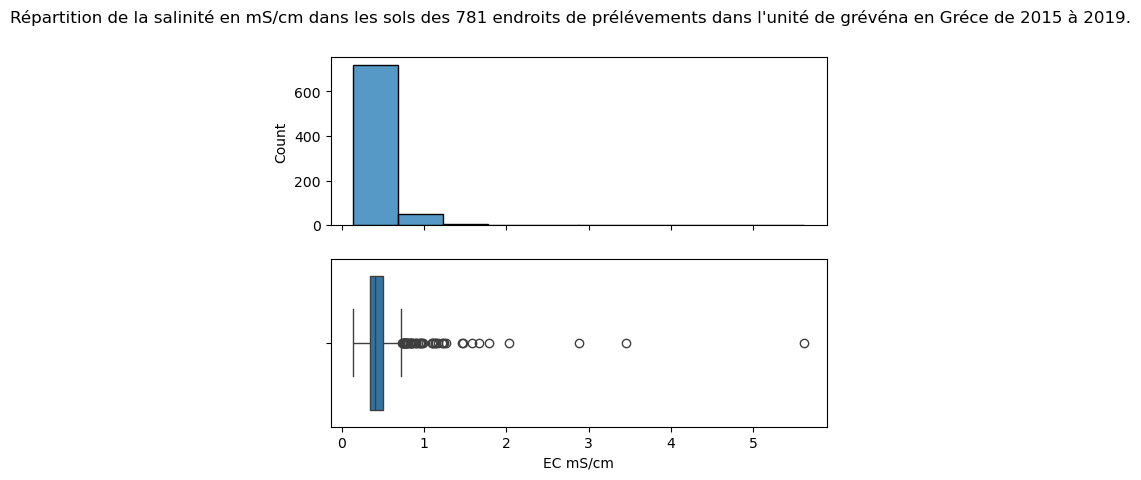

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition de la salinité en mS/cm dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.histplot(data = df, x="EC mS/cm", bins = 10, ax=ax[0])
sns.boxplot(data = df, x="EC mS/cm", ax=ax[1])
plt.show()

Nous observons que tous les sols présentent une salinité de type A, comprise entre 0 et 2 mS/cm. Il existe également de nombreuses valeurs aberrantes, dont la majorité reste toutefois de type A. On recense deux outliers de type B (entre 2 et 4 mS/cm) et un seul de type C (entre 4 et 8 mS/cm). La plupart des sols affichent donc une salinité similaire et, par conséquent, n’ont pas de salinité problématique, ce qui permet de cultiver différents types de plantes.

Même si la plupart des sols sont de type A, nous allons visualiser la salinité en fonction de leur type afin d’examiner l’influence de la salinité sur les nutriments. Étant donné que la quasi-totalité des valeurs se situent entre 0 et 2, nous allons focaliser l’analyse sur cet intervalle.

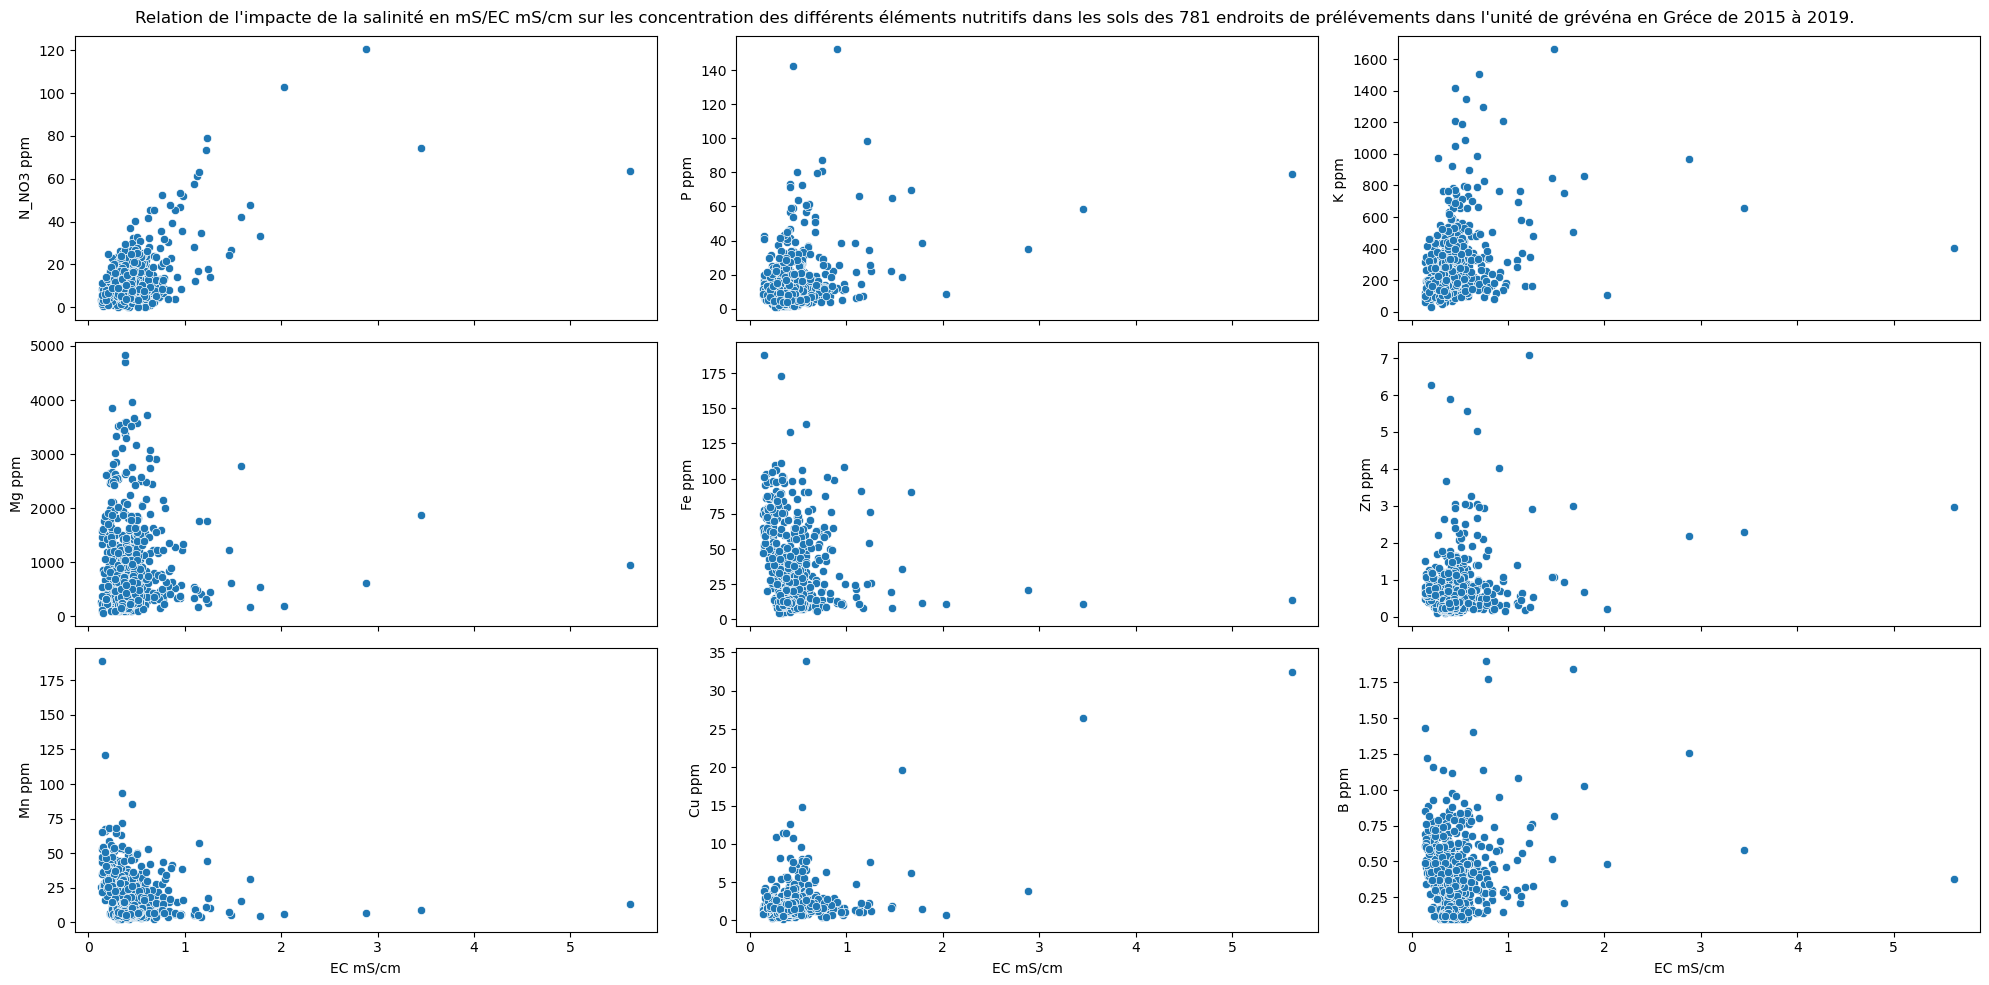

In [21]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation de l'impacte de la salinité en mS/EC mS/cm sur les concentration des différents éléments nutritifs dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.scatterplot(data = df, x="EC mS/cm", y = "N_NO3 ppm", ax=ax[0, 0])
sns.scatterplot(data = df, x="EC mS/cm", y = "P ppm", ax=ax[0, 1])
sns.scatterplot(data = df, x="EC mS/cm", y = "K ppm ",ax=ax[0, 2])
sns.scatterplot(data = df, x="EC mS/cm", y = "Mg ppm", ax=ax[1, 0])
sns.scatterplot(data = df, x="EC mS/cm", y = "Fe ppm",ax=ax[1, 1])
sns.scatterplot(data = df, x="EC mS/cm", y = "Zn ppm",ax=ax[1, 2])
sns.scatterplot(data = df, x="EC mS/cm", y = "Mn ppm",ax=ax[2, 0])
sns.scatterplot(data = df, x="EC mS/cm", y = "Cu ppm",ax=ax[2, 1])
sns.scatterplot(data = df, x="EC mS/cm", y = "B ppm",ax=ax[2, 2])
fig.tight_layout()
plt.show()

Nous n’observons aucune corrélation entre ces deux variables. Passons donc à une analyse par tests d’hypothèse.

In [22]:
print(spearmanr(df["N_NO3 ppm"], df["EC mS/cm"]))
print(spearmanr(df["P ppm"], df["EC mS/cm"]))
print(spearmanr(df["K ppm "], df["EC mS/cm"]))
print(spearmanr(df["Mg ppm"], df["EC mS/cm"]))
print(spearmanr(df["Fe ppm"], df["EC mS/cm"]))
print(spearmanr(df["Zn ppm"], df["EC mS/cm"]))
print(spearmanr(df["Mn ppm"], df["EC mS/cm"]))
print(spearmanr(df["Cu ppm"], df["EC mS/cm"]))
print(spearmanr(df["B ppm"], df["EC mS/cm"]))

SignificanceResult(statistic=0.2853651958363854, pvalue=4.4147190584215478e-16)
SignificanceResult(statistic=0.2159868192108331, pvalue=1.0971976991026515e-09)
SignificanceResult(statistic=0.2753472293804331, pvalue=4.89673430668452e-15)
SignificanceResult(statistic=-0.01410264977978039, pvalue=0.694132281658526)
SignificanceResult(statistic=-0.16765685807169203, pvalue=2.498443342931694e-06)
SignificanceResult(statistic=0.09478753794226481, pvalue=0.00807320743190715)
SignificanceResult(statistic=-0.16994117270130993, pvalue=1.811872862056021e-06)
SignificanceResult(statistic=0.1695537943165055, pvalue=1.9139135958139604e-06)
SignificanceResult(statistic=-0.014424025245017139, pvalue=0.687525089629124)


Nous constatons qu’il n’y a pas d’influence de la salinité sur les nutriments.

4) Analyse de la teneur en matière organique selon le type de sol

Nous allons à présent examiner la quantité de matière organique (O.M) en fonction du type de sol.

On affirme que plus un sol est riche en matière organique, plus il est fertile. D’après la publication associée à ce jeu de données, le rendement est meilleur lorsque la teneur en matière organique est strictement supérieure à 2 %.

In [23]:
df["O.M. %"].describe()

count    780.000000
mean       2.028651
std        0.627605
min        0.370000
25%        1.590000
50%        1.960000
75%        2.372500
max        4.980000
Name: O.M. %, dtype: float64

On constate qu’en moyenne, les 781 sols prélevés à Grévéna entre 2015 et 2019 possèdent un pourcentage de matière organique légèrement supérieur à 2 %.
Cela signifie qu’en moyenne, ces 781 sols disposent d’une bonne quantité de matière organique. 

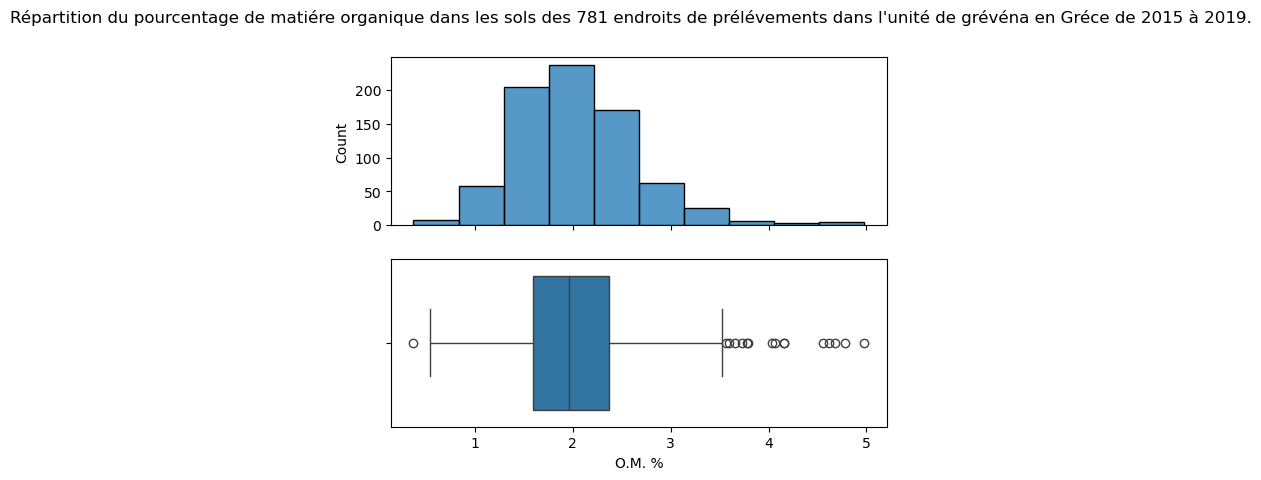

In [24]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition du pourcentage de matiére organique dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.histplot(data = df, x="O.M. %", bins = 10, ax=ax[0])
sns.boxplot(data = df, x="O.M. %", ax=ax[1])
plt.show()

On remarque que le pourcentage de matière organique suit une loi normale.
La plupart des sols présentent entre 1,5 % et 2,5 % de matière organique.
On constate un outlier à gauche et plusieurs outliers à droite.
Environ 47 % des sols affichent une teneur en matière organique supérieure à 2 %.
De nombreux sols très riches en matière organique sont considérés comme des valeurs aberrantes.
Nous allons maintenant examiner la proportion de sols ayant plus ou moins de 2 % de matière organique.

In [25]:
conditionlist = [
    (df["O.M. %"] > 2)
]

choicelist = ["O.M. % > 2"]
df["groupe OM"] = np.select(conditionlist, choicelist, default="O.M. % <= 2")
df

,ID,Sand %,Clay %,Silt %,pH,EC mS/cm,O.M. %,CACO3 %,N_NO3 ppm,P ppm,K ppm,Mg ppm,Fe ppm,Zn ppm,Mn ppm,Cu ppm,B ppm,groupe pH,groupe OM
0,1,42.0,38.0,20.0,5.162,0.274,3.783414,0.00,14.462366,18.608840,147,1115,91.32,0.894,27.060,1.768,0.40,acide,O.M. % > 2
1,2,54.0,26.0,20.0,6.071,0.355,1.451688,0.00,14.587814,32.742137,180,1055,60.04,3.660,17.580,1.684,0.41,neutre,O.M. % <= 2
2,3,28.0,36.0,36.0,6.921,0.675,1.767599,0.40,14.910394,19.024525,183,1215,61.24,3.060,18.000,1.840,0.46,neutre,O.M. % <= 2
3,4,58.0,20.0,22.0,7.704,0.355,0.718322,6.80,4.211470,6.276846,116,327,19.54,1.640,5.040,0.844,0.50,basique,O.M. % <= 2
4,5,33.2,41.2,25.6,7.609,0.392,0.996625,4.39,6.111111,6.553970,228,939,25.84,0.180,7.160,1.216,0.40,basique,O.M. % <= 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,777,26.0,46.0,28.0,6.720,0.454,2.080000,0.00,7.660000,20.670000,395,500,38.07,0.394,26.480,1.468,0.33,neutre,O.M. % > 2
777,778,40.0,28.0,32.0,7.790,0.343,1.380000,30.00,5.200000,4.140000,286,154,12.79,0.241,6.328,0.603,0.12,basique,O.M. % <= 2
778,779,34.0,28.0,38.0,7.630,1.135,1.870000,24.30,17.130000,6.900000,582,164,10.73,0.439,5.390,1.141,0.26,basique,O.M. % <= 2
779,780,16.0,38.0,46.0,7.730,0.393,1.720000,46.30,3.920000,7.930000,335,572,11.61,0.263,3.770,2.195,0.27,basique,O.M. % <= 2


groupe OM
O.M. % <= 2    416
O.M. % > 2     364
Name: count, dtype: int64
groupe OM
O.M. % <= 2    0.533333
O.M. % > 2     0.466667
Name: proportion, dtype: float64


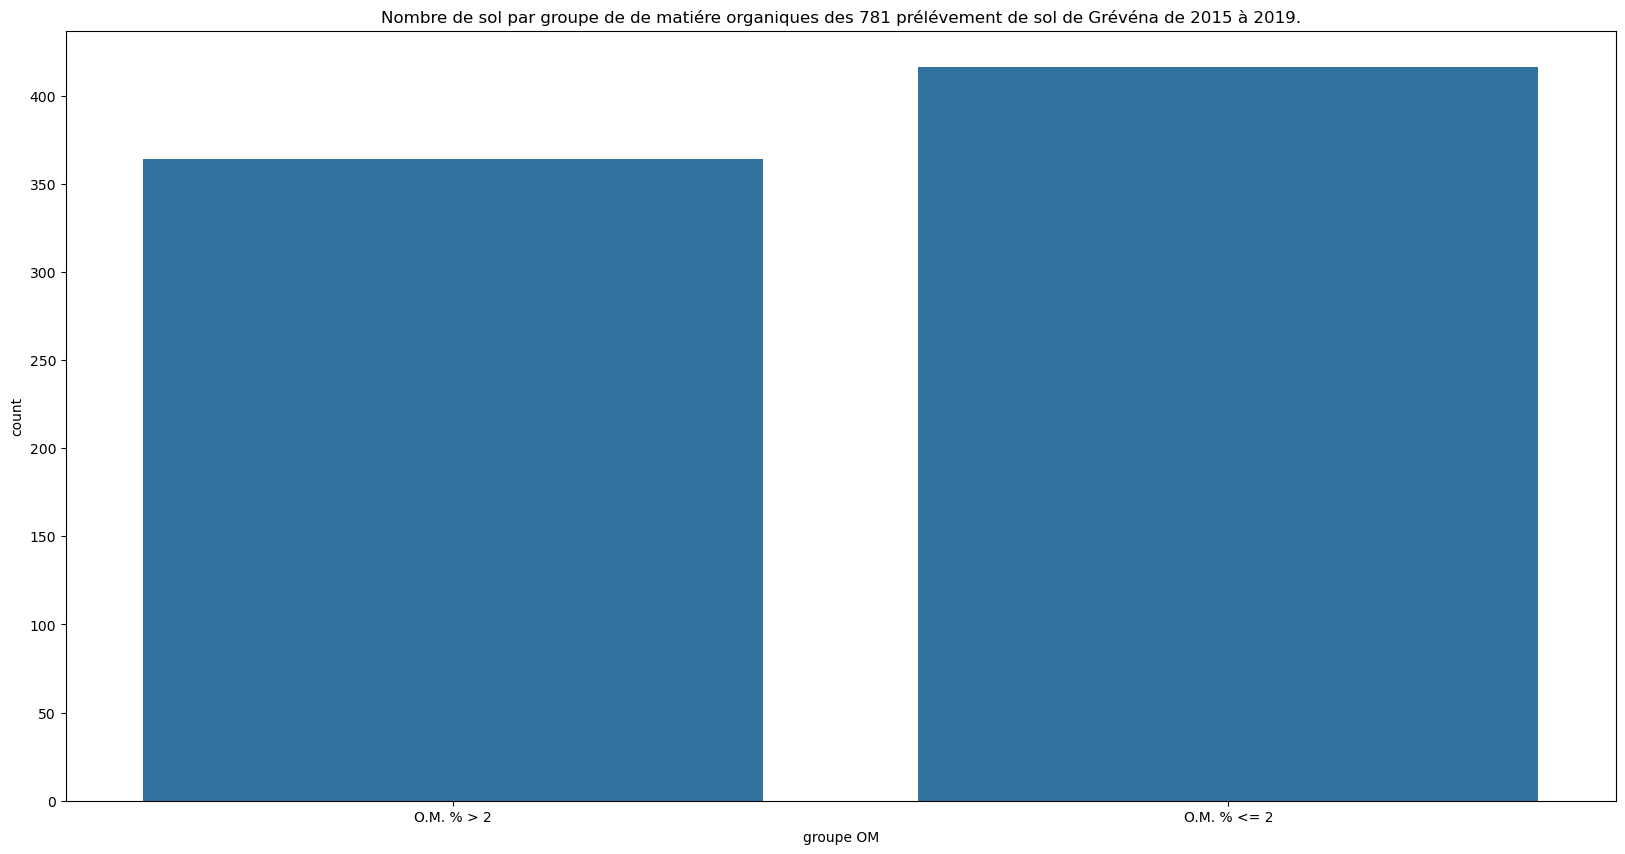

In [26]:
print(df["groupe OM"].value_counts())
print(df["groupe OM"].value_counts(normalize=True))
plt.figure(figsize=(20, 10))
sns.countplot(data = df, x="groupe OM")
plt.title("Nombre de sol par groupe de de matiére organiques des 781 prélévement de sol de Grévéna de 2015 à 2019.")
plt.show()

On observe qu’il y a davantage de sols dont la teneur en matière organique est inférieure à 2 %.
Cependant, le nombre de sols dont la teneur est supérieure à 2 % reste presque équivalent.
La plupart des sols nécessitent tout de même un apport supplémentaire de matière organique.
Nous allons à présent étudier l’influence du pourcentage de matière organique sur les nutriments.

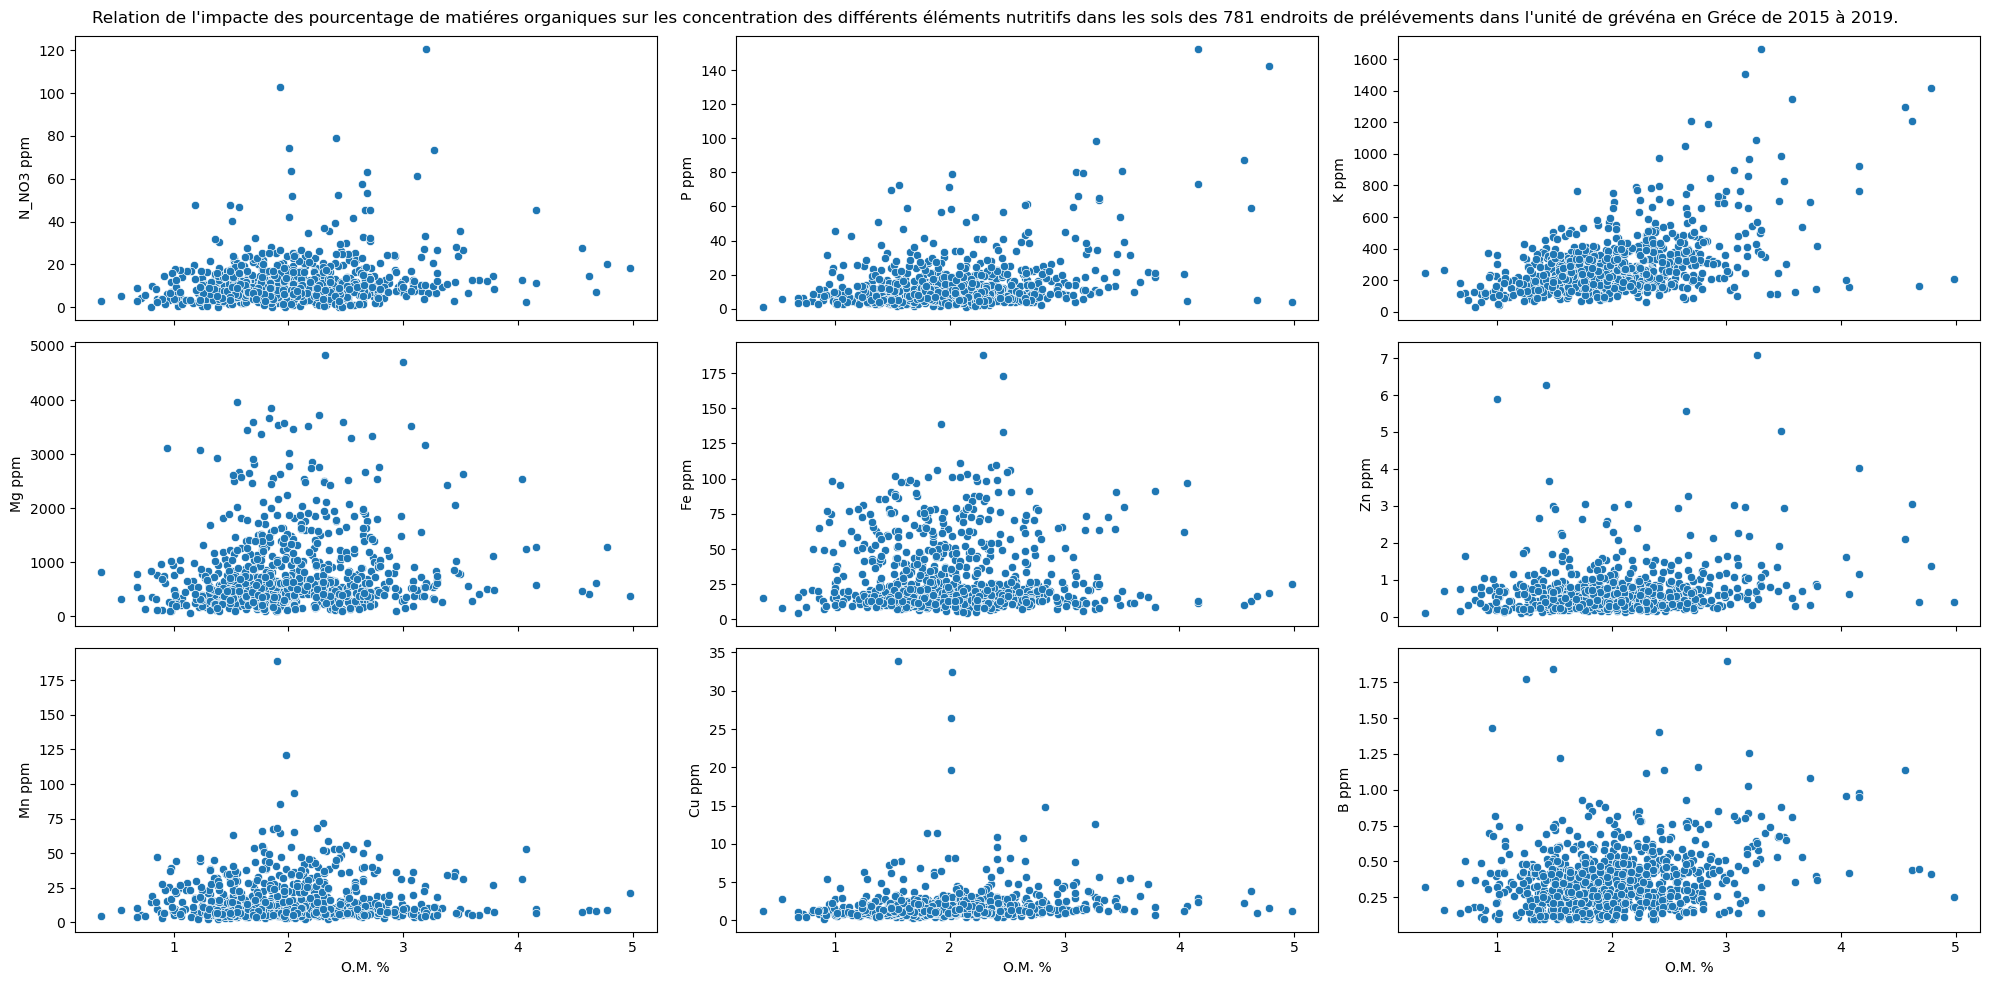

In [27]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation de l'impacte des pourcentage de matiéres organiques sur les concentration des différents éléments nutritifs dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.scatterplot(data = df, x="O.M. %", y = "N_NO3 ppm", ax=ax[0, 0])
sns.scatterplot(data = df, x="O.M. %", y = "P ppm", ax=ax[0, 1])
sns.scatterplot(data = df, x="O.M. %", y = "K ppm ",ax=ax[0, 2])
sns.scatterplot(data = df, x="O.M. %", y = "Mg ppm", ax=ax[1, 0])
sns.scatterplot(data = df, x="O.M. %", y = "Fe ppm",ax=ax[1, 1])
sns.scatterplot(data = df, x="O.M. %", y = "Zn ppm",ax=ax[1, 2])
sns.scatterplot(data = df, x="O.M. %", y = "Mn ppm",ax=ax[2, 0])
sns.scatterplot(data = df, x="O.M. %", y = "Cu ppm",ax=ax[2, 1])
sns.scatterplot(data = df, x="O.M. %", y = "B ppm",ax=ax[2, 2])
fig.tight_layout()
plt.show()

Nous ne voyons aucune relation particulière.
Nous allons donc utiliser des tests d’hypothèse pour le confirmer.

In [28]:
print(spearmanr(df["N_NO3 ppm"], df["O.M. %"]))
print(spearmanr(df["P ppm"], df["O.M. %"]))
print(spearmanr(df["K ppm "], df["O.M. %"]))
print(spearmanr(df["Mg ppm"], df["O.M. %"]))
print(spearmanr(df["Fe ppm"], df["O.M. %"]))
print(spearmanr(df["Zn ppm"], df["O.M. %"]))
print(spearmanr(df["Mn ppm"], df["O.M. %"]))
print(spearmanr(df["Cu ppm"], df["O.M. %"]))
print(spearmanr(df["B ppm"], df["O.M. %"]))

SignificanceResult(statistic=0.21546570561649508, pvalue=1.2053701049910155e-09)
SignificanceResult(statistic=0.24596281663617917, pvalue=3.2692506233112187e-12)
SignificanceResult(statistic=0.43754230544211453, pvalue=8.172468569710708e-38)
SignificanceResult(statistic=0.14395481089164996, pvalue=5.459630400720637e-05)
SignificanceResult(statistic=-0.010745317364067123, pvalue=0.7644611169522788)
SignificanceResult(statistic=0.21100292466124276, pvalue=2.670589134929458e-09)
SignificanceResult(statistic=0.004270051372414674, pvalue=0.9052235971669154)
SignificanceResult(statistic=0.24136091838826543, pvalue=8.416128355945029e-12)
SignificanceResult(statistic=0.20782481132833536, pvalue=4.656354057610071e-09)


Nous constatons qu’il n’existe pas de corrélation significative.

5) Analyse du pourcentage de CaCO₃.

In [29]:
df["CACO3 %"].describe()

count    780.000000
mean      13.437974
std       13.382813
min        0.000000
25%        1.800000
50%        8.755000
75%       22.000000
max       77.600000
Name: CACO3 %, dtype: float64

La moyenne du pourcentage de CaCO₃ dans les 781 sols de Grévéna, de 2015 à 2019, est de 13,42 %.
Nous savons que cette teneur peut influer sur l’alcalinité des sols et, par conséquent, un taux élevé de CaCO₃ peut rendre les sols basiques.
Examinons maintenant la répartition de cette variable. 

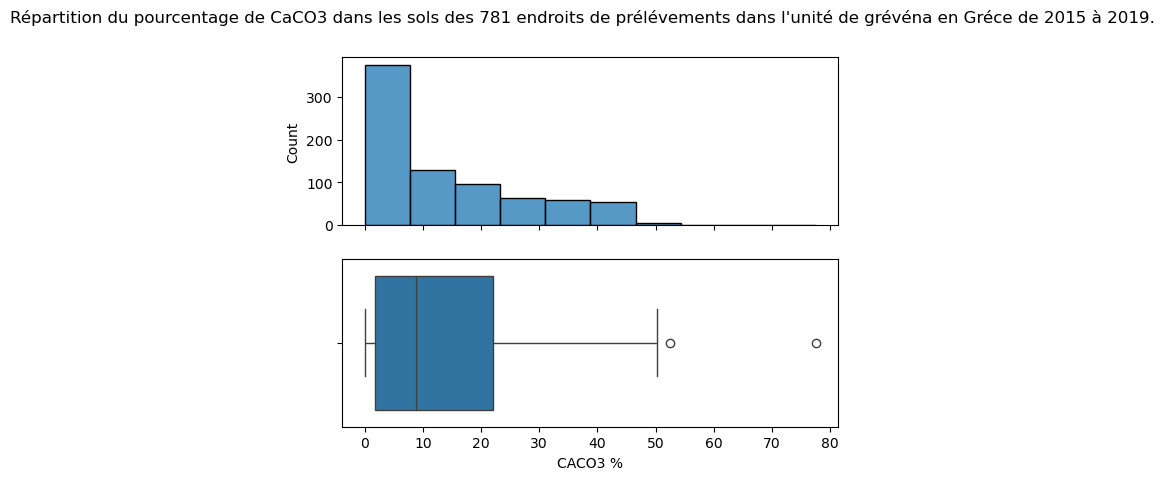

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition du pourcentage de CaCO3 dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.histplot(data = df, x="CACO3 %", bins = 10, ax=ax[0])
sns.boxplot(data = df, x="CACO3 %", ax=ax[1])
plt.show()

On constate que la plupart des sols de ce jeu de données possèdent un pourcentage de carbonate de calcium compris entre 0 et 10 %.
On note également que cette variable ne suit pas une distribution normale.
Il existe deux outliers au-delà de 50 %.
Comme le CaCO₃ permet de réguler le pH, nous allons étudier son influence au moyen d’un diagramme de dispersion (scatterplot).

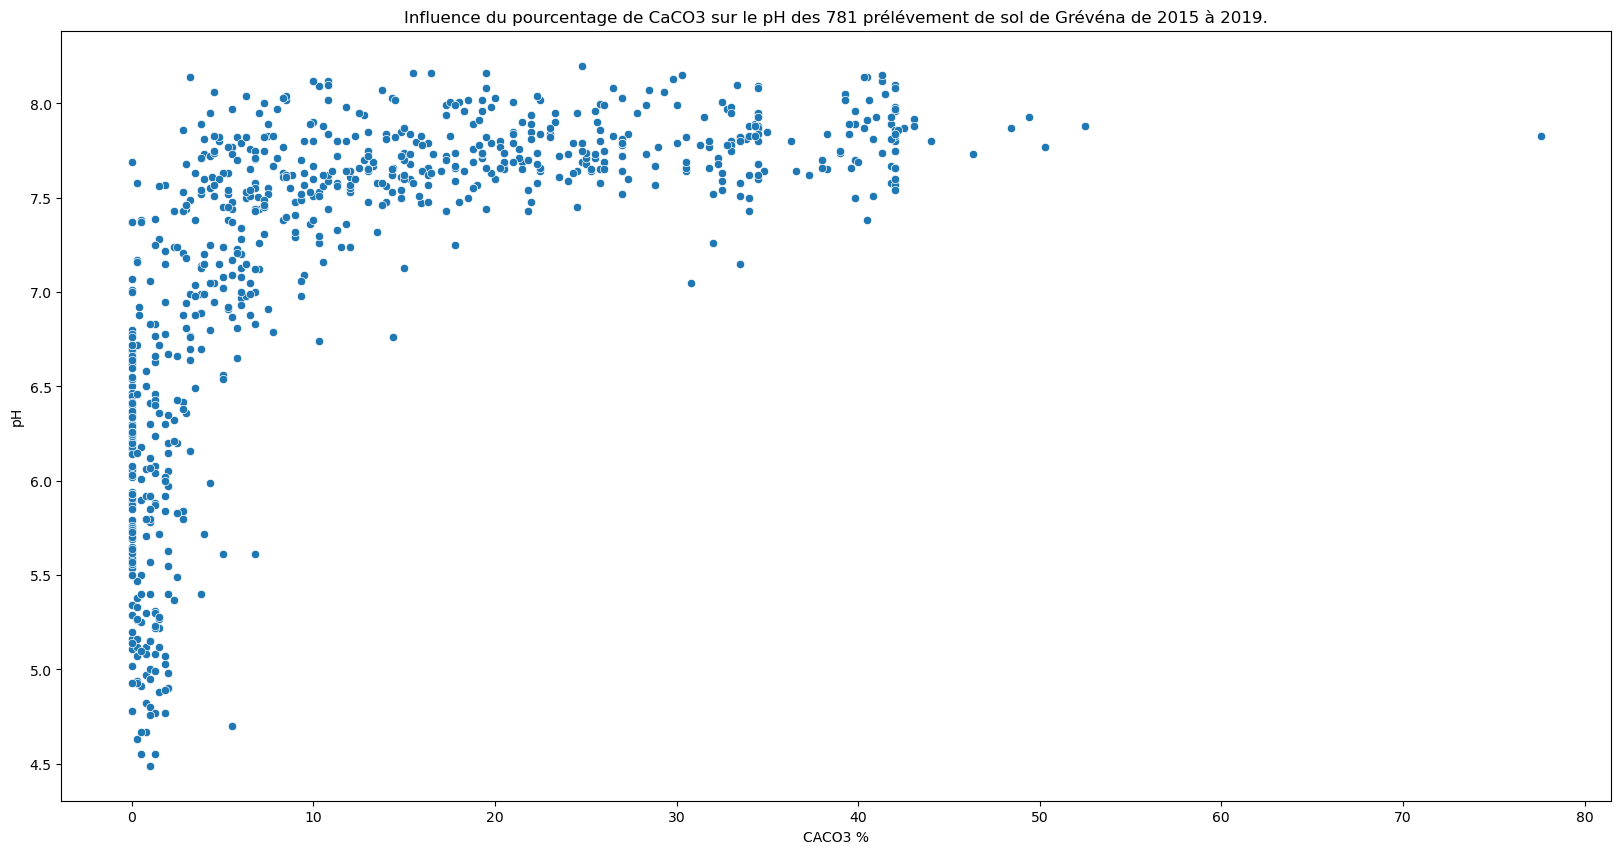

In [31]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data = df, x="CACO3 %", y="pH")
plt.title("Influence du pourcentage de CaCO3 sur le pH des 781 prélévement de sol de Grévéna de 2015 à 2019.")
plt.show()

Nous remarquons qu’il existe nettement une relation entre le pourcentage de CaCO₃ et le pH.
On constate qu’entre 0 et 10 %, l’influence est forte et qu’au-delà de 10 %, le pH se stabilise aux alentours de 7,7.
Analysons maintenant le coefficient de Spearman.

In [32]:
spearmanr(df["CACO3 %"], df["pH"])

SignificanceResult(statistic=0.7866518933035971, pvalue=4.161640399255252e-165)

Nous voyons clairement une très bonne corrélation entre ces deux variables.
Cela signifie que, si l’on souhaite augmenter le pH, il faut ajouter du CaCO₃.
Inversement, si l’on veut faire baisser le pH, il faut réduire la teneur en CaCO₃.
Passons maintenant à l’influence du pourcentage de CaCO₃ sur les nutriments.

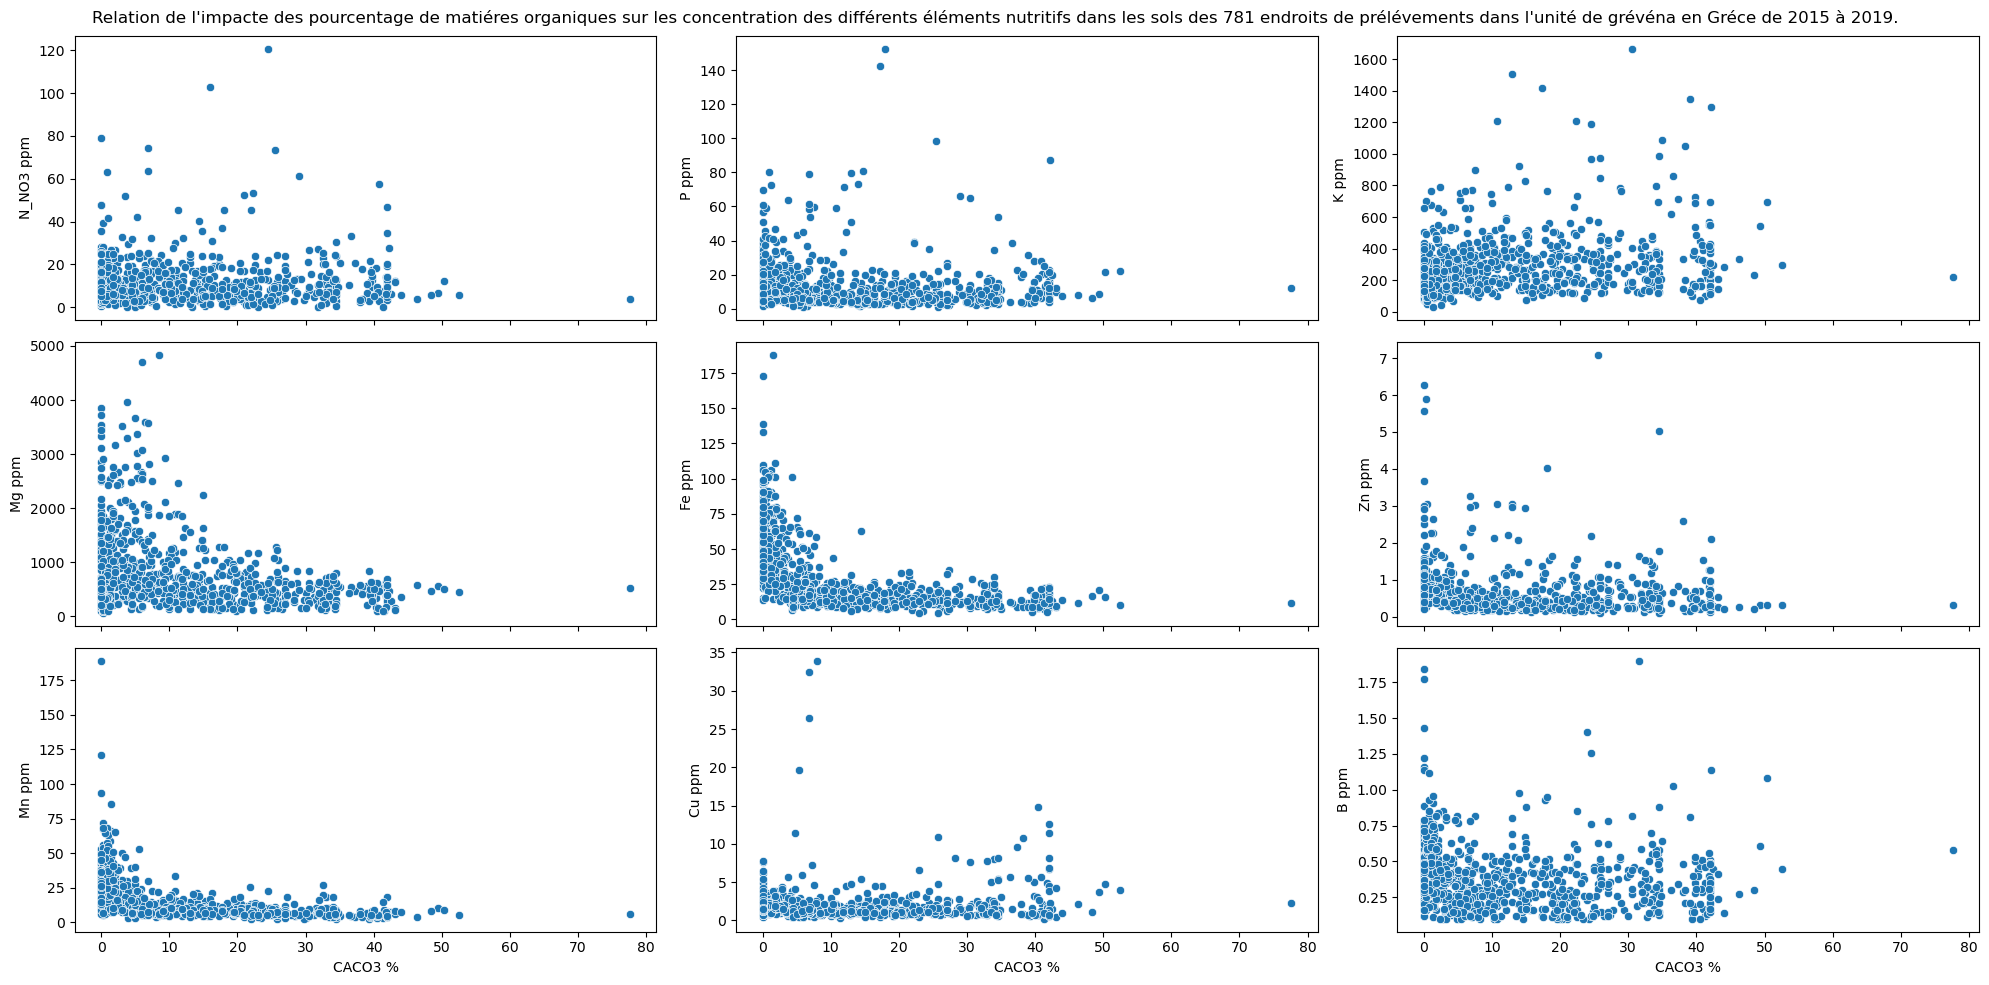

In [33]:
fig, ax = plt.subplots(3, 3, sharex=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation de l'impacte des pourcentage de matiéres organiques sur les concentration des différents éléments nutritifs dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")
sns.scatterplot(data = df, x="CACO3 %", y = "N_NO3 ppm", ax=ax[0, 0])
sns.scatterplot(data = df, x="CACO3 %", y = "P ppm", ax=ax[0, 1])
sns.scatterplot(data = df, x="CACO3 %", y = "K ppm ",ax=ax[0, 2])
sns.scatterplot(data = df, x="CACO3 %", y = "Mg ppm", ax=ax[1, 0])
sns.scatterplot(data = df, x="CACO3 %", y = "Fe ppm",ax=ax[1, 1])
sns.scatterplot(data = df, x="CACO3 %", y = "Zn ppm",ax=ax[1, 2])
sns.scatterplot(data = df, x="CACO3 %", y = "Mn ppm",ax=ax[2, 0])
sns.scatterplot(data = df, x="CACO3 %", y = "Cu ppm",ax=ax[2, 1])
sns.scatterplot(data = df, x="CACO3 %", y = "B ppm",ax=ax[2, 2])
fig.tight_layout()
plt.show()

In [34]:
print(spearmanr(df["N_NO3 ppm"], df["O.M. %"]))
print(spearmanr(df["P ppm"], df["O.M. %"]))
print(spearmanr(df["K ppm "], df["O.M. %"]))
print(spearmanr(df["Mg ppm"], df["O.M. %"]))
print(spearmanr(df["Fe ppm"], df["O.M. %"]))
print(spearmanr(df["Zn ppm"], df["O.M. %"]))
print(spearmanr(df["Mn ppm"], df["O.M. %"]))
print(spearmanr(df["Cu ppm"], df["O.M. %"]))
print(spearmanr(df["B ppm"], df["O.M. %"]))

SignificanceResult(statistic=0.21546570561649508, pvalue=1.2053701049910155e-09)
SignificanceResult(statistic=0.24596281663617917, pvalue=3.2692506233112187e-12)
SignificanceResult(statistic=0.43754230544211453, pvalue=8.172468569710708e-38)
SignificanceResult(statistic=0.14395481089164996, pvalue=5.459630400720637e-05)
SignificanceResult(statistic=-0.010745317364067123, pvalue=0.7644611169522788)
SignificanceResult(statistic=0.21100292466124276, pvalue=2.670589134929458e-09)
SignificanceResult(statistic=0.004270051372414674, pvalue=0.9052235971669154)
SignificanceResult(statistic=0.24136091838826543, pvalue=8.416128355945029e-12)
SignificanceResult(statistic=0.20782481132833536, pvalue=4.656354057610071e-09)


On constate qu’il n’y a pas de corrélations significatives.

6) Analyse entre les facteurs

Nous allons maintenant analyser les relations entre les facteurs.
Nous savons que plus la teneur en limon est élevée, moins la quantité de magnésium est importante.
Examinons quel facteur est corrélé au limon.  

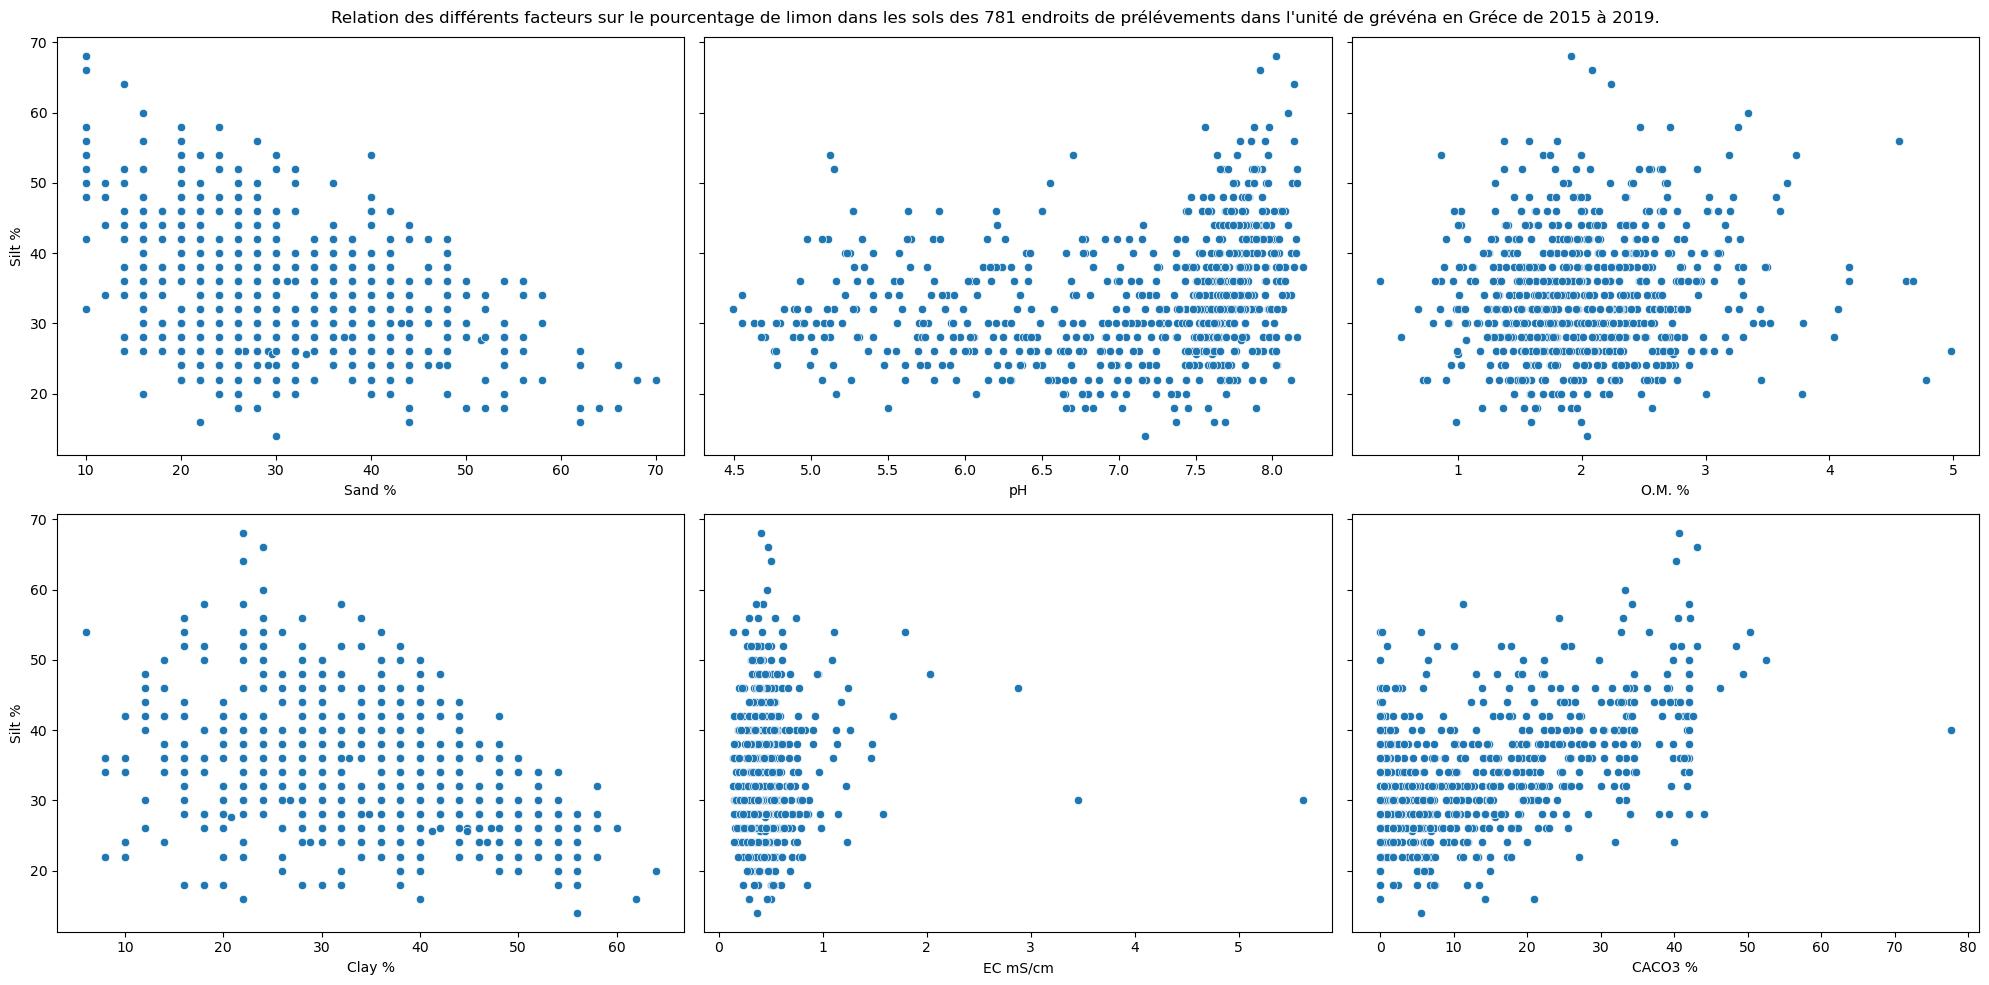

PearsonRResult(statistic=-0.34879385756572434, pvalue=9.88856203145829e-24)
PearsonRResult(statistic=-0.40480712259904283, pvalue=4.0833646996706007e-32)
SignificanceResult(statistic=0.36460873955827616, pvalue=6.196347879091183e-26)
PearsonRResult(statistic=0.11044910719399526, pvalue=0.002007066528070826)
SignificanceResult(statistic=0.09505839947179325, pvalue=0.007893378915296036)
SignificanceResult(statistic=0.3919561580900349, pvalue=4.7981462163384204e-30)


In [35]:
fig, ax = plt.subplots(2, 3, sharey=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation des différents facteurs sur le pourcentage de limon dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")

#create pie chart
sns.scatterplot(data = df, x="Sand %", y = "Silt %", ax=ax[0, 0])
sns.scatterplot(data = df, x="Clay %", y = "Silt %", ax=ax[1, 0])
sns.scatterplot(data = df, x="pH", y = "Silt %",ax=ax[0, 1])
sns.scatterplot(data = df, x="EC mS/cm", y = "Silt %", ax=ax[1, 1])
sns.scatterplot(data = df, x="O.M. %", y = "Silt %",ax=ax[0, 2])
sns.scatterplot(data = df, x="CACO3 %", y = "Silt %",ax=ax[1, 2])
fig.tight_layout()
plt.show()

print(pearsonr(df["Sand %"], df["Silt %"]))
print(pearsonr(df["Clay %"], df["Silt %"]))
print(spearmanr(df["pH"], df["Silt %"]))
print(pearsonr(df["O.M. %"], df["Silt %"]))
print(spearmanr(df["EC mS/cm"], df["Silt %"]))
print(spearmanr(df["CACO3 %"], df["Silt %"]))

On constate qu’il n’existe pas de forte corrélation entre les différents facteurs.
Nous savons cependant que l’argile influe sur la quantité de magnésium.

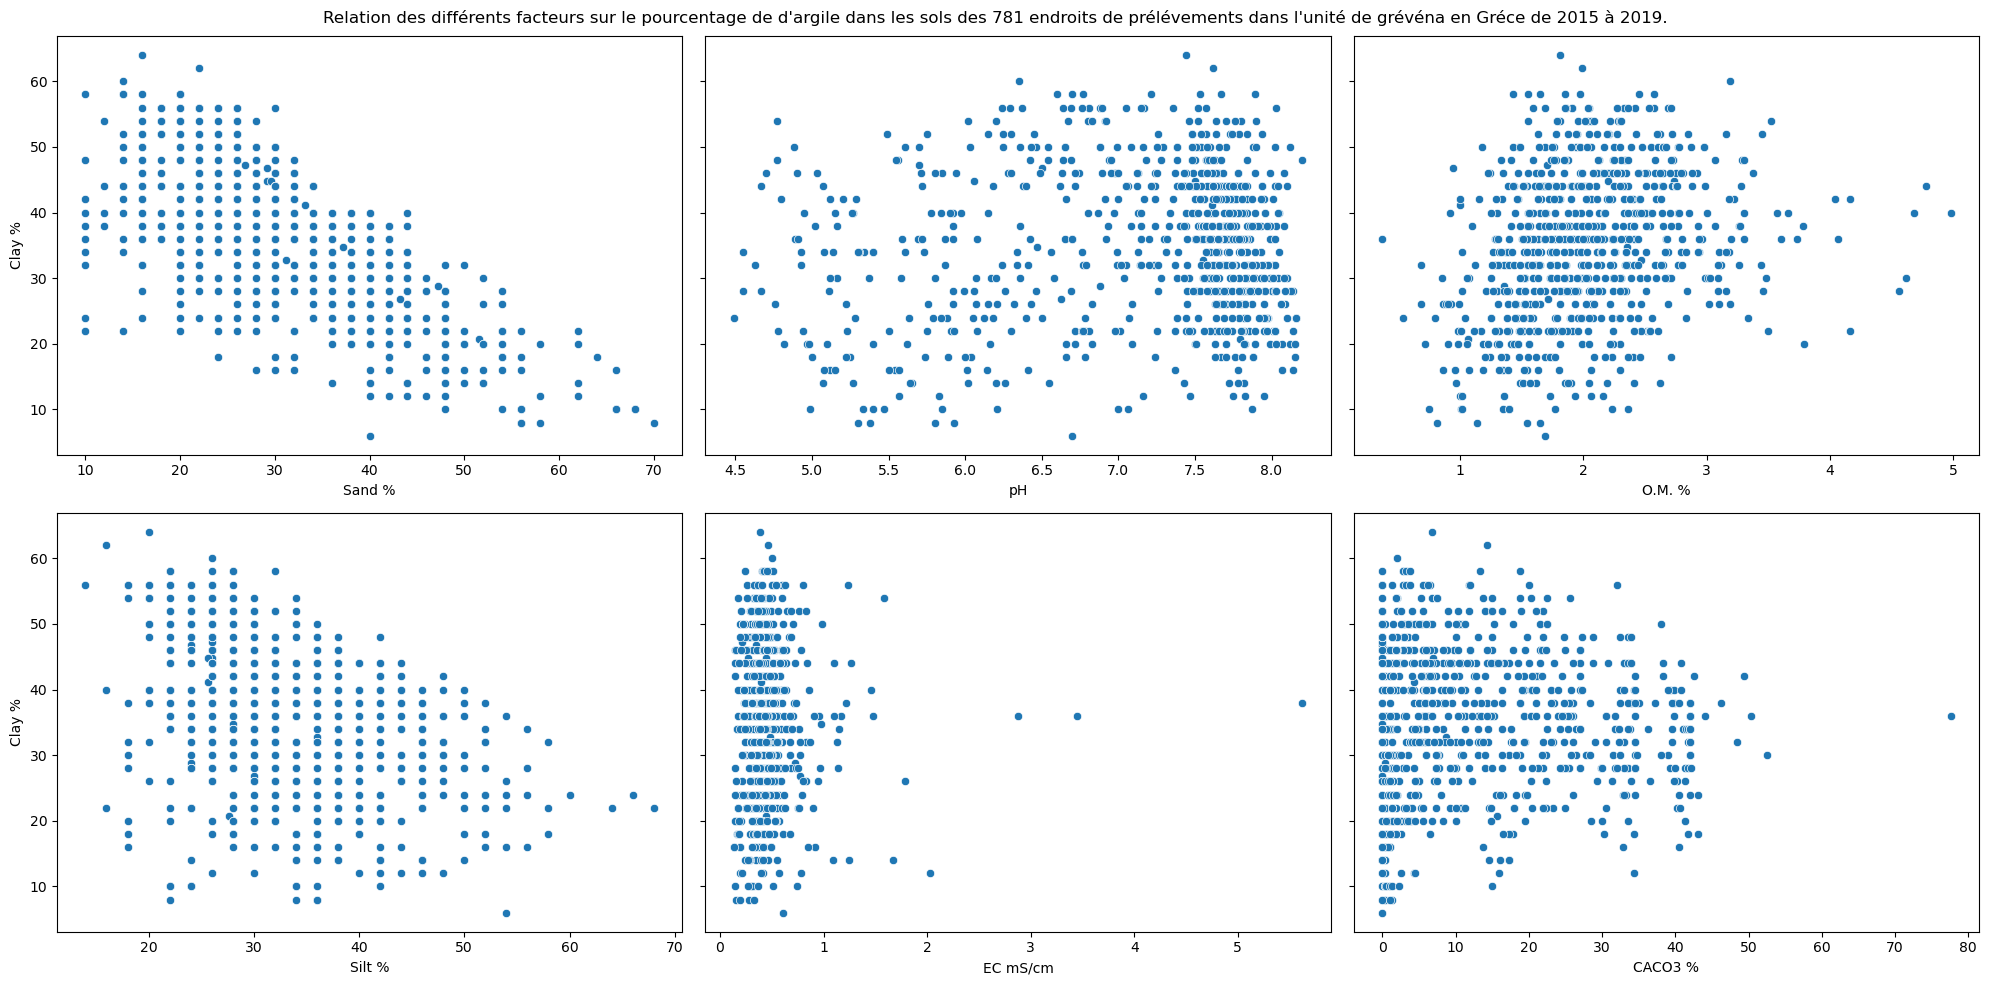

PearsonRResult(statistic=-0.7157829212407343, pvalue=1.8913337439336743e-123)
PearsonRResult(statistic=-0.4048071225990427, pvalue=4.0833646996706007e-32)
SignificanceResult(statistic=-0.03908219966208024, pvalue=0.2756371856539696)
PearsonRResult(statistic=0.26944739126737194, pvalue=1.9299537749073284e-14)
SignificanceResult(statistic=0.03992518524487869, pvalue=0.2654055254866914)
SignificanceResult(statistic=0.044659490384381766, pvalue=0.21280366852558297)


In [36]:
fig, ax = plt.subplots(2, 3, sharey=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation des différents facteurs sur le pourcentage de d'argile dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")

#create pie chart
sns.scatterplot(data = df, x="Sand %", y = "Clay %", ax=ax[0, 0])
sns.scatterplot(data = df, x="Silt %", y = "Clay %", ax=ax[1, 0])
sns.scatterplot(data = df, x="pH", y = "Clay %",ax=ax[0, 1])
sns.scatterplot(data = df, x="EC mS/cm", y = "Clay %", ax=ax[1, 1])
sns.scatterplot(data = df, x="O.M. %", y = "Clay %",ax=ax[0, 2])
sns.scatterplot(data = df, x="CACO3 %", y = "Clay %",ax=ax[1, 2])
fig.tight_layout()
plt.show()

print(pearsonr(df["Sand %"], df["Clay %"]))
print(pearsonr(df["Silt %"], df["Clay %"]))
print(spearmanr(df["pH"], df["Clay %"]))
print(pearsonr(df["O.M. %"], df["Clay %"]))
print(spearmanr(df["EC mS/cm"], df["Clay %"]))
print(spearmanr(df["CACO3 %"], df["Clay %"]))

Il existe une corrélation négative très significative concernant le pourcentage de sable.
Si l’on augmente le pourcentage d’argile, on diminue le pourcentage de sable et, par conséquent, on accroît la teneur en magnésium.
Par ailleurs, nous avions observé que le pH fait baisser la quantité de fer dans les sols.

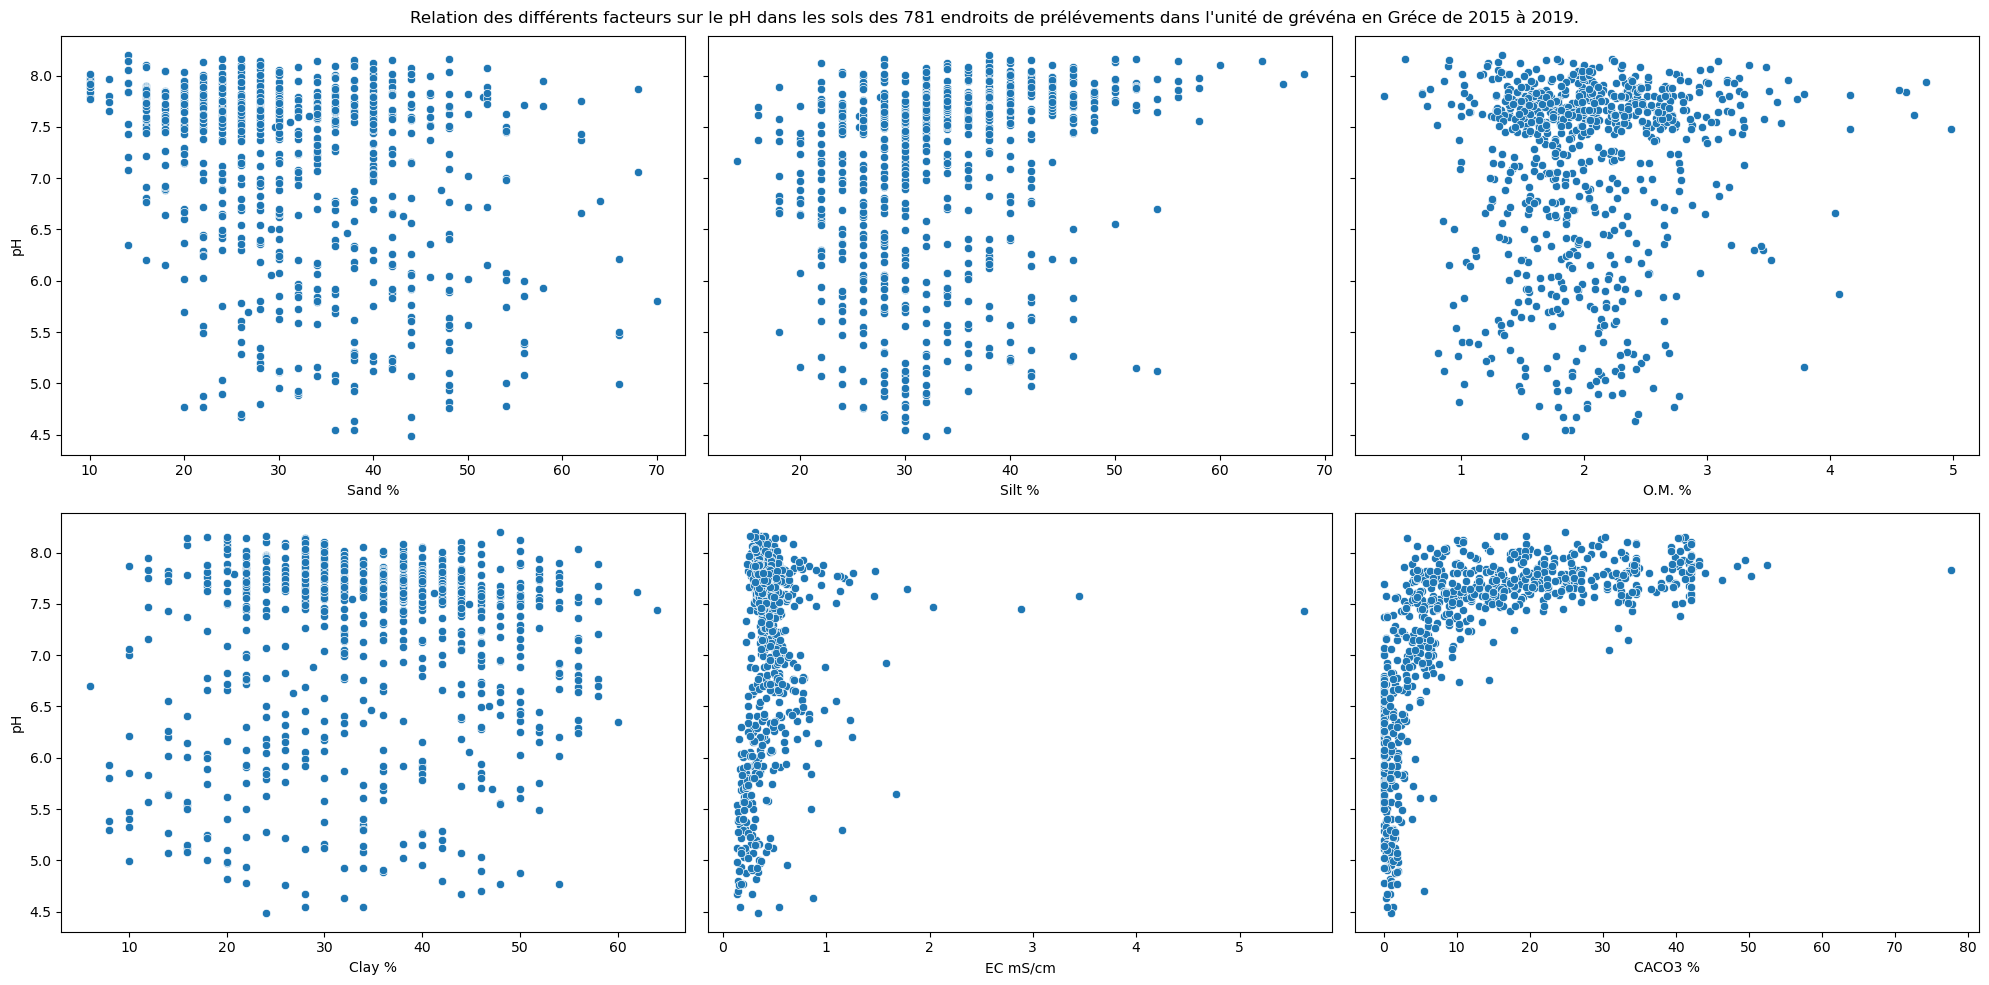

PearsonRResult(statistic=-0.2894257262143796, pvalue=1.6186144071668077e-16)
PearsonRResult(statistic=0.09718801729134198, pvalue=0.006599744185696952)
PearsonRResult(statistic=0.24854826290209223, pvalue=1.905547884845046e-12)
PearsonRResult(statistic=0.10541165097388411, pvalue=0.003203742537459924)
SignificanceResult(statistic=0.17697093419602683, pvalue=6.561482567504423e-07)
SignificanceResult(statistic=0.7866518933035971, pvalue=4.161640399255252e-165)


In [37]:
fig, ax = plt.subplots(2, 3, sharey=True)
fig.set_size_inches(20, 10)
plt.suptitle("Relation des différents facteurs sur le pH dans les sols des 781 endroits de prélévements dans l'unité de grévéna en Gréce de 2015 à 2019.")

#create pie chart
sns.scatterplot(data = df, x="Sand %", y = "pH", ax=ax[0, 0])
sns.scatterplot(data = df, x="Clay %", y = "pH", ax=ax[1, 0])
sns.scatterplot(data = df, x="Silt %", y = "pH",ax=ax[0, 1])
sns.scatterplot(data = df, x="EC mS/cm", y = "pH", ax=ax[1, 1])
sns.scatterplot(data = df, x="O.M. %", y = "pH",ax=ax[0, 2])
sns.scatterplot(data = df, x="CACO3 %", y = "pH",ax=ax[1, 2])
fig.tight_layout()
plt.show()

print(pearsonr(df["Sand %"], df["pH"]))
print(pearsonr(df["Clay %"], df["pH"]))
print(pearsonr(df["Silt %"], df["pH"]))
print(pearsonr(df["O.M. %"], df["pH"]))
print(spearmanr(df["EC mS/cm"], df["pH"]))
print(spearmanr(df["CACO3 %"], df["pH"]))

Nous constatons que seul le pourcentage de CaCO₃ permet d’influer sur le pH.
Par conséquent, si l’on réduit la teneur en CaCO₃, on abaisse le pH, ce qui augmente la capacité du sol à retenir le fer.

Le pH diminue de manière logarithmique avec l’augmentation de CaCO₃.   

III) Régréssion

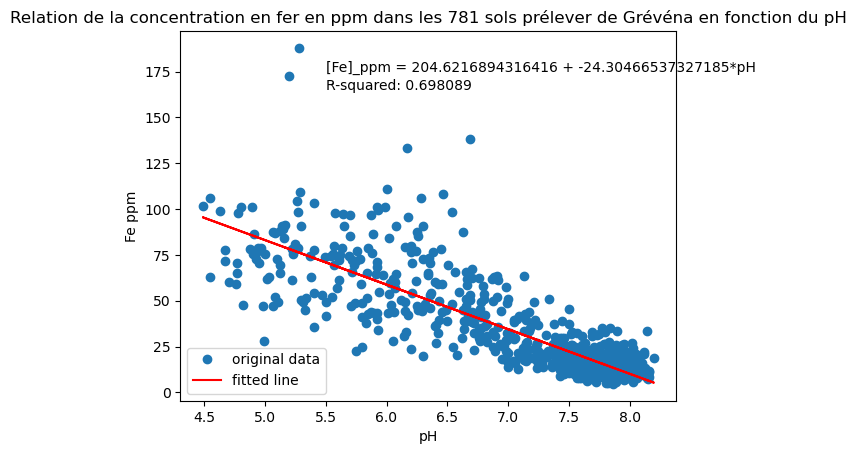

In [38]:
res = linregress(df["pH"], df["Fe ppm"])
plt.plot(df["pH"], df["Fe ppm"], 'o', label='original data')
plt.plot(df["pH"], res.intercept + res.slope*df["pH"], 'r', label='fitted line')
plt.title("Relation de la concentration en fer en ppm dans les 781 sols prélever de Grévéna en fonction du pH")
plt.xlabel("pH")
plt.ylabel("Fe ppm")
plt.text(5.5, 165, f"R-squared: {res.rvalue**2:.6f}")
plt.text(5.5, 175, f"[Fe]_ppm = {res.intercept} + {res.slope}*pH")
plt.legend()
plt.show()

Nous observons clairement une relation linéaire négative entre la concentration en fer et le pH.
Ainsi, il est possible d’accroître la teneur en fer en acidifiant les sols.

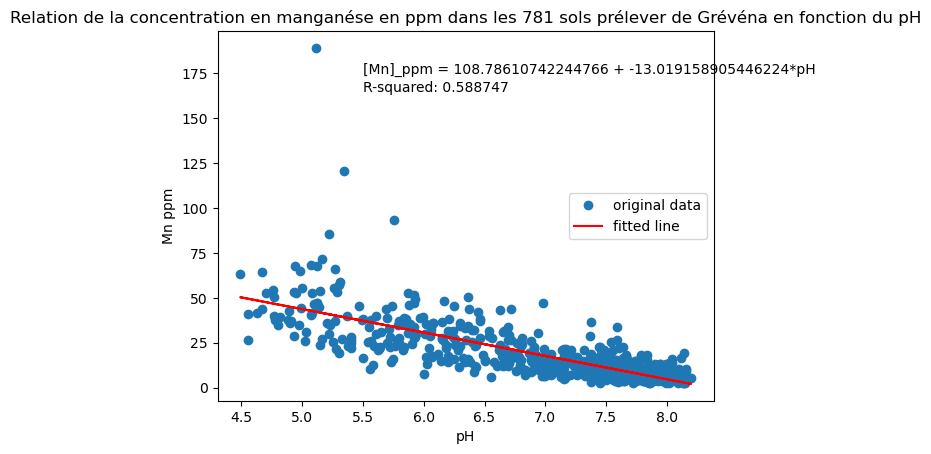

In [39]:
res = linregress(df["pH"], df["Mn ppm"])
plt.plot(df["pH"], df["Mn ppm"], 'o', label='original data')
plt.plot(df["pH"], res.intercept + res.slope*df["pH"], 'r', label='fitted line')
plt.title("Relation de la concentration en manganése en ppm dans les 781 sols prélever de Grévéna en fonction du pH")
plt.xlabel("pH")
plt.ylabel("Mn ppm")
plt.text(5.5, 165, f"R-squared: {res.rvalue**2:.6f}")
plt.text(5.5, 175, f"[Mn]_ppm = {res.intercept} + {res.slope}*pH")
plt.legend()
plt.show()

Nous notons également une relation linéaire et négative entre la concentration en manganèse et le pH.
Par conséquent, on peut augmenter la teneur en manganèse en acidifiant les sols.
Ces deux relations ont été mises en évidence dans la publication.

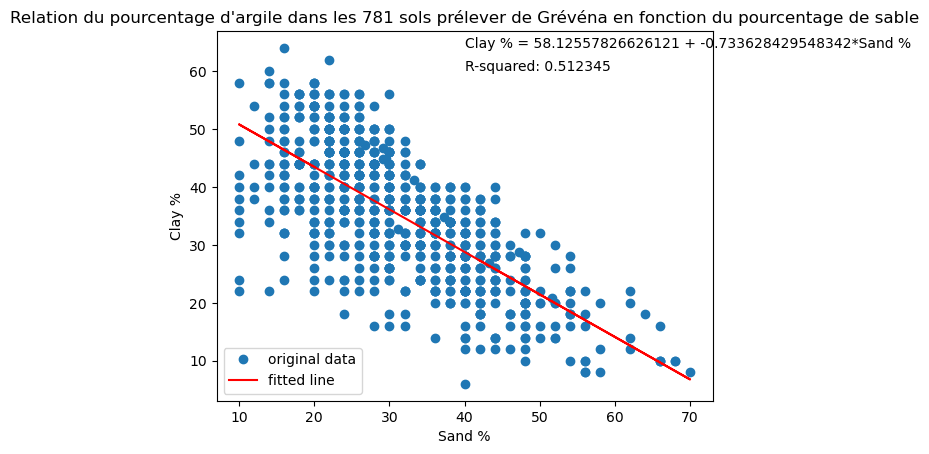

In [40]:
res = linregress(df["Sand %"], df["Clay %"])
plt.plot(df["Sand %"], df["Clay %"], 'o', label='original data')
plt.plot(df["Sand %"], res.intercept + res.slope*df["Sand %"], 'r', label='fitted line')
plt.title("Relation du pourcentage d'argile dans les 781 sols prélever de Grévéna en fonction du pourcentage de sable")
plt.xlabel("Sand %")
plt.ylabel("Clay %")
plt.text(40, 60, f"R-squared: {res.rvalue**2:.6f}")
plt.text(40, 64, f"Clay % = {res.intercept} + {res.slope}*Sand %")
plt.legend()
plt.show()

Nous constatons une relation négative entre le pourcentage de sable et le pourcentage d’argile.
Étant donné que l’argile permet une meilleure rétention du manganèse lors des pluies, l’augmentation du pourcentage d’argile peut être bénéfique.
Ce que nous allons faire maintenant, c’est concevoir un modèle de machine learning plus précis, tenant compte de tous les facteurs identifiés au cours de l’analyse statistique.